# Image colorization using U-Net architecture

## Initialization

In [1]:
# Install required libraries
!pip install -U scipy torch_snippets torch_summary h5py
!git clone https://github.com/sizhky/CSRNet-pytorch.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 45.8 MB/s eta 

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (92/92), 623.74 KiB | 17.82 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [2]:
# Import libraries
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from torchvision import transforms as T
from torch_snippets import *

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Tue Mar 19 22:21:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Download CIFAR-10 dataset
data_folder = '~/cifar10/cifar/'
datasets.CIFAR10(data_folder, download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 46438754.81it/s]


Extracting /root/cifar10/cifar/cifar-10-python.tar.gz to /root/cifar10/cifar/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /root/cifar10/cifar/
    Split: Train

In [5]:
# Create Dataset class to fetch images and labels
class ColorizeDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root, train)

    def __getitem__(self, idx):
        image, _ = super().__getitem__(idx)
        bw_image = image.convert('L').convert('RGB') # Convert to grayscale
        bw_image, image = np.array(bw_image) / 255., np.array(image) / 255.
        bw_image, image = [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw_image, image]]
        return bw_image, image

In [6]:
# Create the train and validation datasets
train_ds = ColorizeDataset(data_folder, train=True)
val_ds = ColorizeDataset(data_folder, train=False)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 256):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

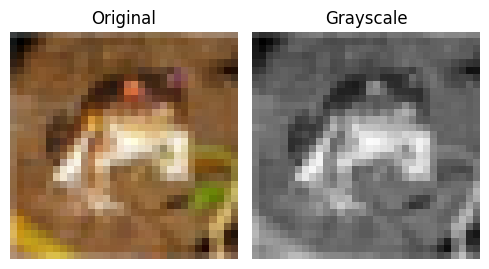

In [11]:
# Display a sample image
bw_image, image = train_ds[0]
subplots([image, bw_image], titles=['Original', 'Grayscale'], nc=2)

In [12]:
# Create all the necessary classes for the UNet model

# Create a class for the Identity layer
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

# Create a class for the Downsampling layer
class DownConv(nn.Module):
    def __init__(self, n_inputs, n_outputs, maxpool=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(n_inputs, n_outputs, 3, padding=1),
            nn.BatchNorm2d(n_outputs),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n_outputs, n_outputs, 3, padding=1),
            nn.BatchNorm2d(n_outputs),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.model(x)

# Create a class for the Upsampling layer
class UpConv(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(n_inputs, n_outputs, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(n_outputs + n_outputs, n_outputs, 3, padding=1),
            nn.BatchNorm2d(n_outputs),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(n_outputs, n_outputs, 3, padding=1),
            nn.BatchNorm2d(n_outputs),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x, y], axis=1)
        x = self.convlayers(x)
        return x

In [13]:
# Create a class for the UNet model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownConv(3, 64, maxpool=False)
        self.d2 = DownConv(64, 128)
        self.d3 = DownConv(128, 256)
        self.d4 = DownConv(256, 512)
        self.d5 = DownConv(512, 1024)
        self.u5 = UpConv(1024, 512)
        self.u4 = UpConv(512, 256)
        self.u3 = UpConv(256, 128)
        self.u2 = UpConv(128, 64)
        self.u1 = nn.Conv2d(64, 3, kernel_size=1, stride=1)

    def forward(self, x):
        x0 = self.d1(x)         # 32
        x1 = self.d2(x0)        # 16
        x2 = self.d3(x1)        # 8
        x3 = self.d4(x2)        # 4
        x4 = self.d5(x3)        # 2
        _x4 = self.u5(x4, x3)   # 4
        _x3 = self.u4(_x4, x2)  # 8
        _x2 = self.u3(_x3, x1)  # 16
        _x1 = self.u2(_x2, x0)  # 32
        return self.u1(_x1)     # 3

In [14]:
# Create a function to load the model
def load_model():
    model = UNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return model, criterion, optimizer

In [15]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    bw_images, images = data
    pred_images = model(bw_images)
    loss = criterion(pred_images, images)
    loss.backward()
    optimizer.step()
    return loss.item()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    bw_images, images = data
    pred_images = model(bw_images)
    loss = criterion(pred_images, images)
    return loss.item()

EPOCH: 0.250  train_loss: 0.008  (18.14s - 7237.07s remaining)

EPOCH: 0.255  train_loss: 0.008  (18.46s - 7216.78s remaining)

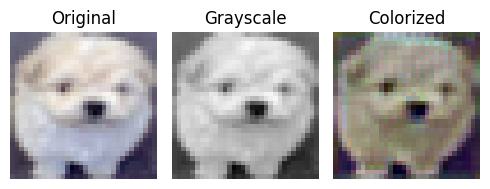

EPOCH: 0.505  train_loss: 0.007  (34.92s - 6879.03s remaining)

EPOCH: 0.510  train_loss: 0.006  (35.25s - 6872.95s remaining)

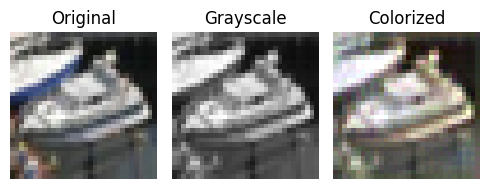

EPOCH: 0.760  train_loss: 0.007  (51.61s - 6737.58s remaining)

EPOCH: 0.765  train_loss: 0.006  (51.93s - 6733.58s remaining)

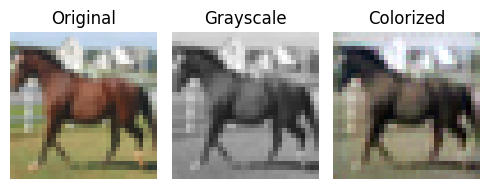

EPOCH: 1.000  val_loss: 0.004  (74.41s - 7366.76s remaining)

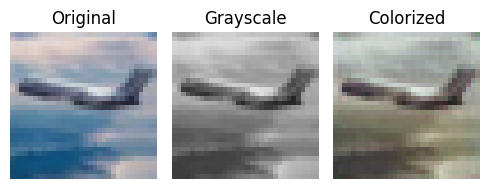

EPOCH: 1.250  train_loss: 0.005  (90.64s - 7160.50s remaining)

EPOCH: 1.255  train_loss: 0.005  (90.96s - 7156.40s remaining)

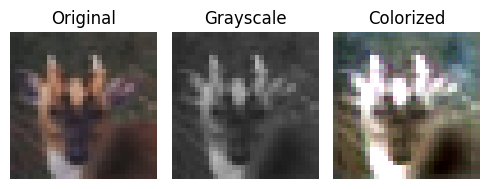

EPOCH: 1.510  train_loss: 0.005  (107.51s - 7011.16s remaining)

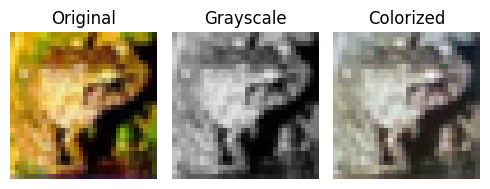

EPOCH: 1.760  train_loss: 0.006  (123.85s - 6912.04s remaining)

EPOCH: 1.765  train_loss: 0.006  (124.17s - 6909.52s remaining)

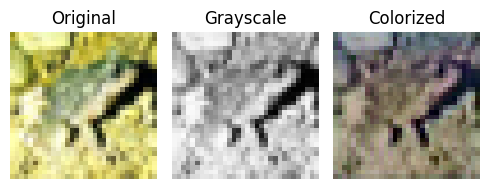

EPOCH: 2.000  val_loss: 0.004  (146.24s - 7165.83s remaining)

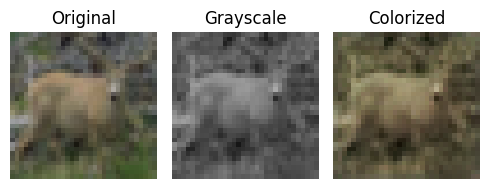

EPOCH: 2.250  train_loss: 0.005  (162.38s - 7054.62s remaining)

EPOCH: 2.255  train_loss: 0.006  (162.70s - 7052.07s remaining)

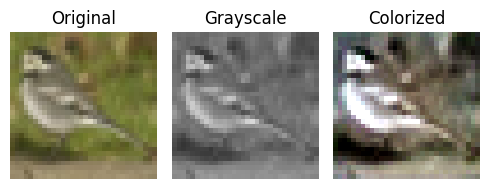

EPOCH: 2.510  train_loss: 0.006  (179.11s - 6956.33s remaining)

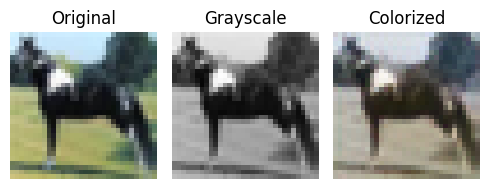

EPOCH: 2.760  train_loss: 0.006  (195.51s - 6887.57s remaining)

EPOCH: 2.765  train_loss: 0.006  (195.83s - 6885.81s remaining)

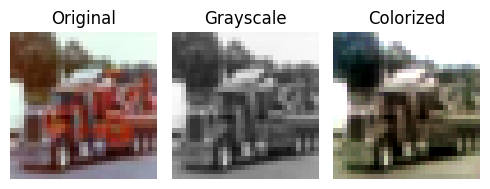

EPOCH: 3.000  val_loss: 0.004  (217.83s - 7043.26s remaining)

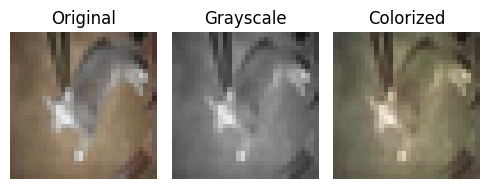

EPOCH: 3.255  train_loss: 0.005  (234.28s - 6963.05s remaining)

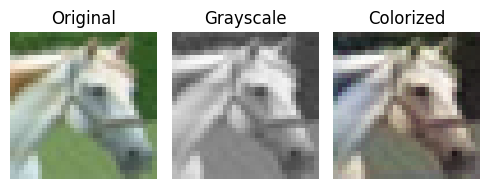

EPOCH: 3.510  train_loss: 0.005  (250.75s - 6892.73s remaining)

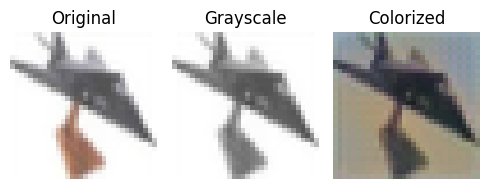

EPOCH: 3.760  train_loss: 0.006  (267.13s - 6837.00s remaining)

EPOCH: 3.765  train_loss: 0.006  (267.45s - 6835.66s remaining)

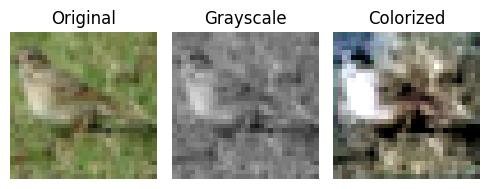

EPOCH: 4.000  val_loss: 0.004  (289.73s - 6953.54s remaining)

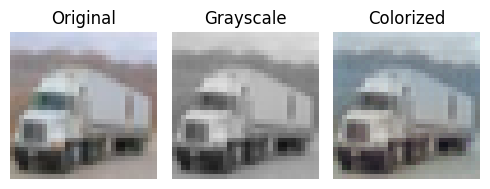

EPOCH: 4.250  train_loss: 0.005  (305.85s - 6890.51s remaining)

EPOCH: 4.255  train_loss: 0.006  (306.17s - 6889.14s remaining)

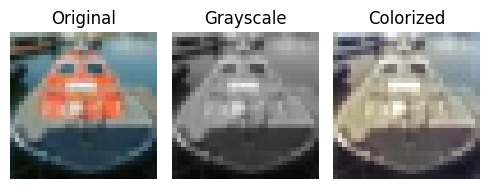

EPOCH: 4.505  train_loss: 0.006  (322.31s - 6832.06s remaining)

EPOCH: 4.510  train_loss: 0.005  (322.66s - 6831.31s remaining)

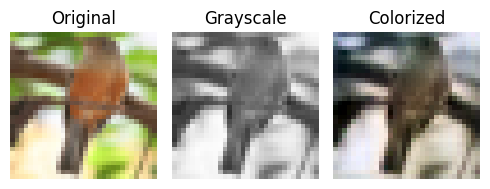

EPOCH: 4.765  train_loss: 0.005  (339.38s - 6782.60s remaining)

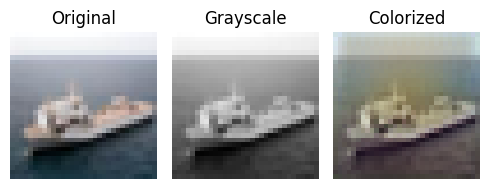

EPOCH: 5.000  val_loss: 0.005  train_loss: 0.005  (361.45s - 6867.56s remaining)


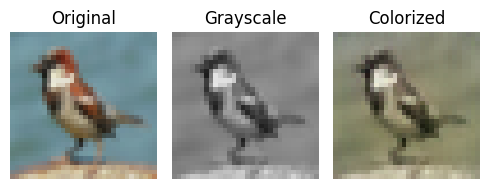

EPOCH: 5.250  train_loss: 0.005  (377.64s - 6815.59s remaining)

EPOCH: 5.255  train_loss: 0.005  (377.96s - 6814.32s remaining)

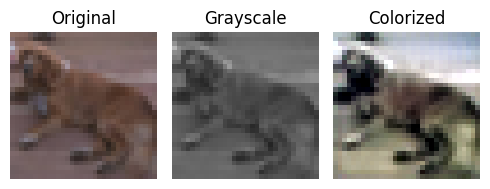

EPOCH: 5.505  train_loss: 0.005  (394.04s - 6763.62s remaining)

EPOCH: 5.510  train_loss: 0.005  (394.39s - 6763.04s remaining)

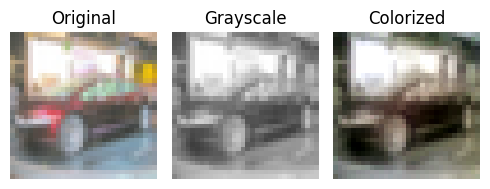

EPOCH: 5.760  train_loss: 0.006  (410.67s - 6718.82s remaining)

EPOCH: 5.765  train_loss: 0.006  (410.99s - 6717.74s remaining)

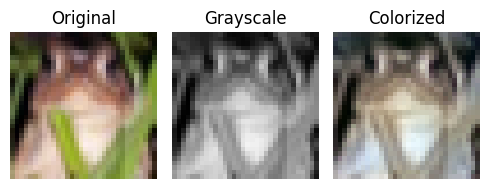

EPOCH: 6.000  val_loss: 0.004  (432.99s - 6783.43s remaining)

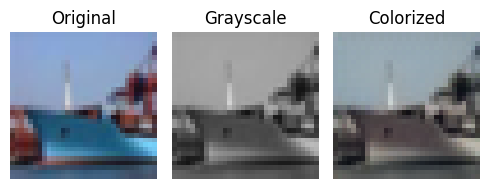

EPOCH: 6.255  train_loss: 0.005  (449.39s - 6734.97s remaining)

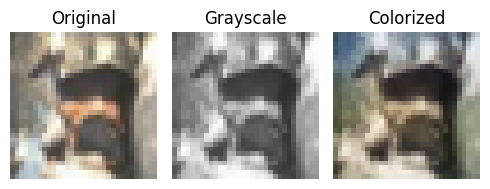

EPOCH: 6.510  train_loss: 0.005  (465.92s - 6690.78s remaining)

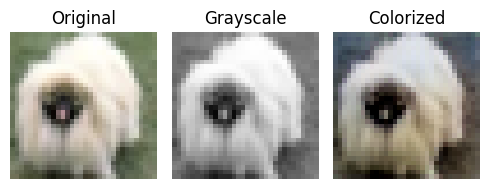

EPOCH: 6.760  train_loss: 0.005  (482.54s - 6655.48s remaining)

EPOCH: 6.765  train_loss: 0.006  (482.86s - 6654.46s remaining)

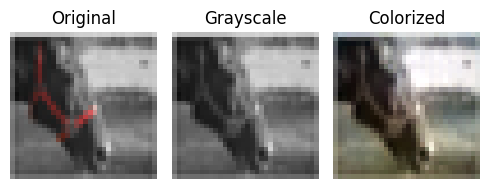

EPOCH: 7.000  val_loss: 0.004  (505.01s - 6709.40s remaining)

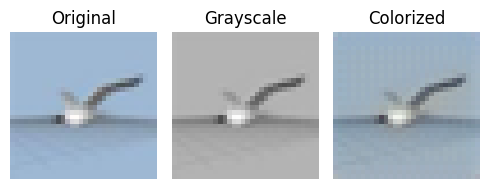

EPOCH: 7.255  train_loss: 0.005  (521.48s - 6666.24s remaining)

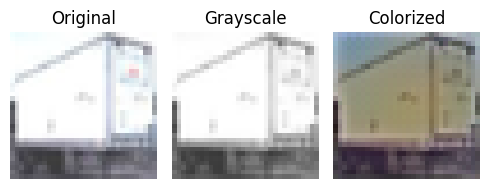

EPOCH: 7.505  train_loss: 0.005  (537.64s - 6626.07s remaining)

EPOCH: 7.510  train_loss: 0.006  (537.99s - 6625.44s remaining)

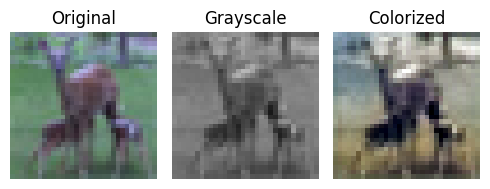

EPOCH: 7.760  train_loss: 0.005  (554.33s - 6588.87s remaining)

EPOCH: 7.765  train_loss: 0.005  (554.65s - 6587.96s remaining)

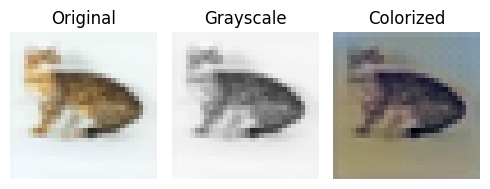

EPOCH: 8.000  val_loss: 0.004  (576.70s - 6632.03s remaining)

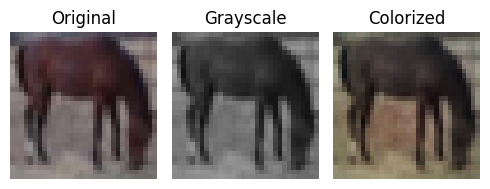

EPOCH: 8.250  train_loss: 0.005  (592.83s - 6592.99s remaining)

EPOCH: 8.255  train_loss: 0.005  (593.15s - 6592.06s remaining)

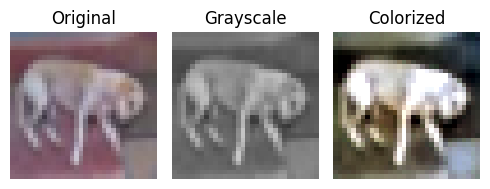

EPOCH: 8.505  train_loss: 0.004  (609.36s - 6555.25s remaining)

EPOCH: 8.510  train_loss: 0.005  (609.70s - 6554.67s remaining)

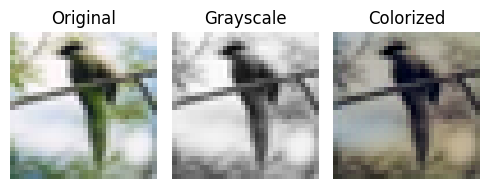

EPOCH: 8.760  train_loss: 0.005  (626.07s - 6520.67s remaining)

EPOCH: 8.765  train_loss: 0.005  (626.39s - 6519.90s remaining)

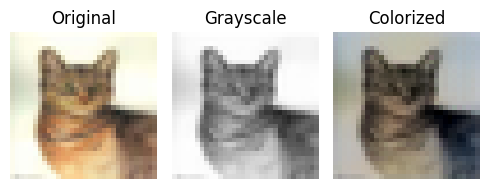

EPOCH: 9.000  val_loss: 0.005  (648.44s - 6556.40s remaining)

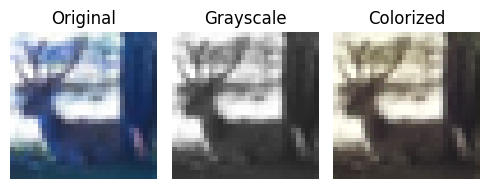

EPOCH: 9.250  train_loss: 0.005  (664.81s - 6522.32s remaining)

EPOCH: 9.255  train_loss: 0.005  (665.12s - 6521.44s remaining)

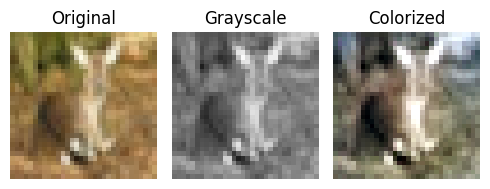

EPOCH: 9.505  train_loss: 0.006  (681.29s - 6486.38s remaining)

EPOCH: 9.510  train_loss: 0.006  (681.64s - 6485.80s remaining)

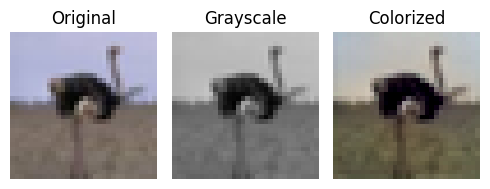

EPOCH: 9.765  train_loss: 0.005  (698.29s - 6452.47s remaining)

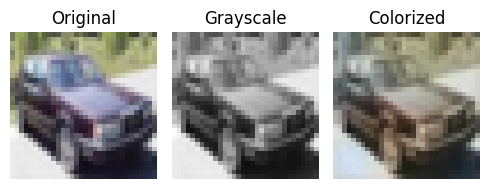

EPOCH: 10.000  val_loss: 0.005  train_loss: 0.005  (720.47s - 6484.23s remaining)


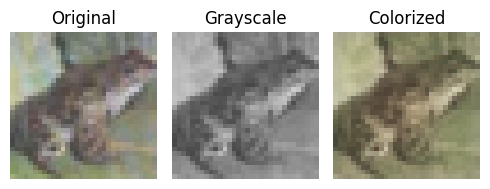

EPOCH: 10.250  train_loss: 0.004  (736.59s - 6449.65s remaining)

EPOCH: 10.255  train_loss: 0.004  (736.91s - 6448.86s remaining)

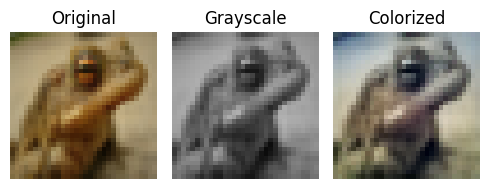

EPOCH: 10.510  train_loss: 0.005  (753.43s - 6415.14s remaining)

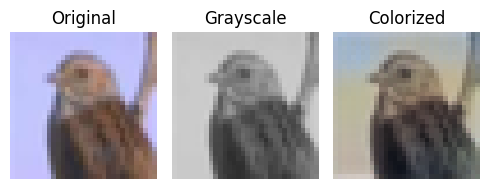

EPOCH: 10.760  train_loss: 0.005  (769.76s - 6383.98s remaining)

EPOCH: 10.765  train_loss: 0.004  (770.08s - 6383.27s remaining)

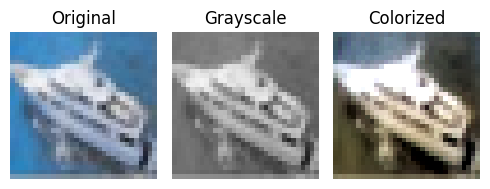

EPOCH: 10.950  val_loss: 0.005  (792.03s - 6441.13s remaining)

EPOCH: 11.000  val_loss: 0.003  (792.23s - 6409.83s remaining)

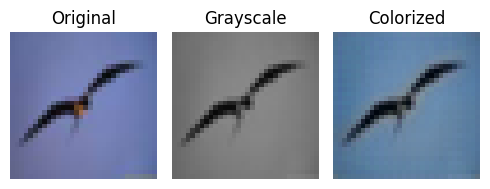

EPOCH: 11.250  train_loss: 0.005  (808.35s - 6377.02s remaining)

EPOCH: 11.255  train_loss: 0.005  (808.68s - 6376.31s remaining)

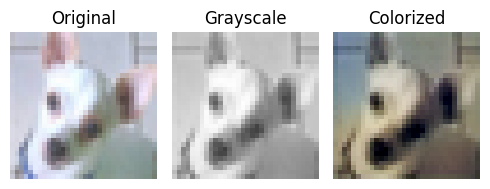

EPOCH: 11.505  train_loss: 0.005  (824.91s - 6345.06s remaining)

EPOCH: 11.510  train_loss: 0.005  (825.26s - 6344.53s remaining)

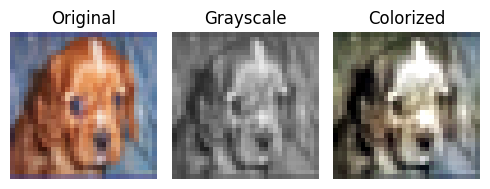

EPOCH: 11.760  train_loss: 0.005  (841.61s - 6314.78s remaining)

EPOCH: 11.765  train_loss: 0.004  (841.93s - 6314.08s remaining)

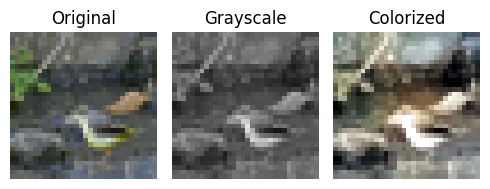

EPOCH: 11.950  val_loss: 0.005  (864.20s - 6367.60s remaining)

EPOCH: 12.000  val_loss: 0.003  (864.40s - 6338.91s remaining)

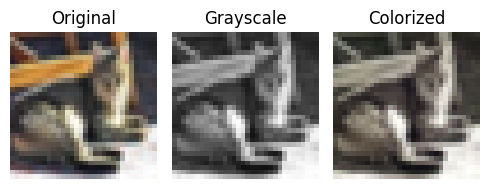

EPOCH: 12.250  train_loss: 0.006  (880.54s - 6307.55s remaining)

EPOCH: 12.255  train_loss: 0.005  (880.86s - 6306.84s remaining)

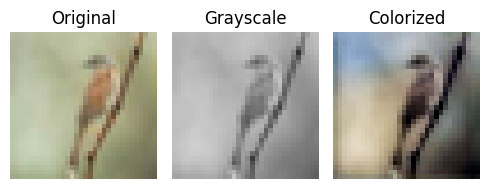

EPOCH: 12.505  train_loss: 0.005  (897.17s - 6277.29s remaining)

EPOCH: 12.510  train_loss: 0.006  (897.53s - 6276.84s remaining)

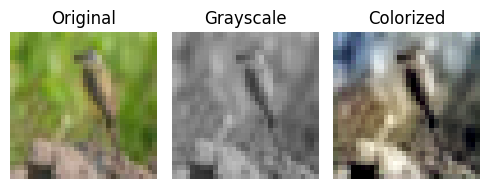

EPOCH: 12.760  train_loss: 0.005  (913.80s - 6247.55s remaining)

EPOCH: 12.765  train_loss: 0.005  (914.13s - 6246.89s remaining)

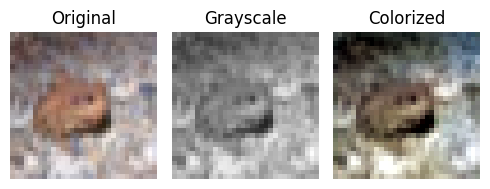

EPOCH: 13.000  val_loss: 0.003  (936.32s - 6266.16s remaining)

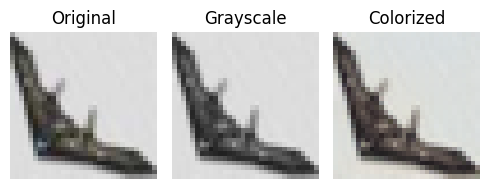

EPOCH: 13.250  train_loss: 0.005  (952.52s - 6236.31s remaining)

EPOCH: 13.255  train_loss: 0.005  (952.84s - 6235.62s remaining)

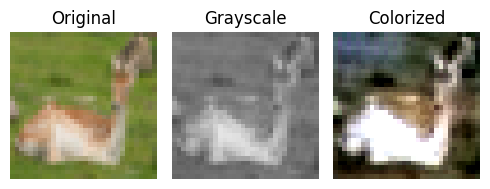

EPOCH: 13.505  train_loss: 0.005  (969.18s - 6207.25s remaining)

EPOCH: 13.510  train_loss: 0.005  (969.54s - 6206.83s remaining)

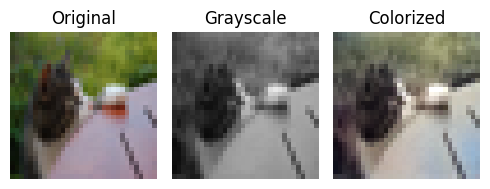

EPOCH: 13.760  train_loss: 0.005  (985.78s - 6178.19s remaining)

EPOCH: 13.765  train_loss: 0.005  (986.10s - 6177.56s remaining)

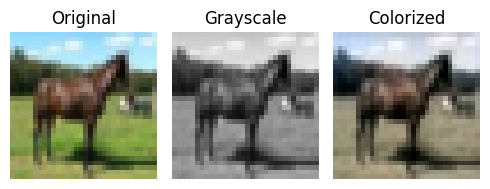

EPOCH: 14.000  val_loss: 0.003  (1008.30s - 6193.87s remaining)

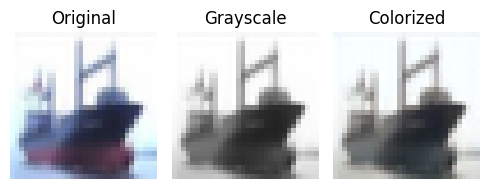

EPOCH: 14.250  train_loss: 0.005  (1024.46s - 6164.73s remaining)

EPOCH: 14.255  train_loss: 0.005  (1024.77s - 6164.04s remaining)

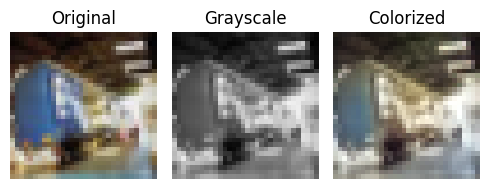

EPOCH: 14.505  train_loss: 0.005  (1041.04s - 6136.01s remaining)

EPOCH: 14.510  train_loss: 0.004  (1041.40s - 6135.63s remaining)

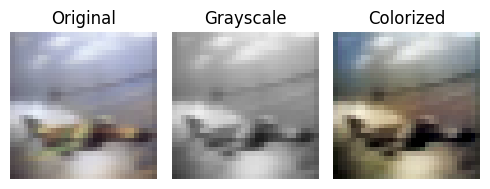

EPOCH: 14.760  train_loss: 0.004  (1057.88s - 6109.21s remaining)

EPOCH: 14.765  train_loss: 0.004  (1058.21s - 6108.67s remaining)

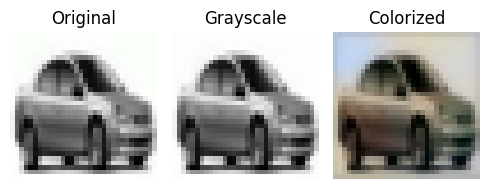

EPOCH: 14.950  val_loss: 0.005  (1080.17s - 6145.06s remaining)

EPOCH: 15.000  val_loss: 0.005  train_loss: 0.005  (1080.36s - 6122.07s remaining)


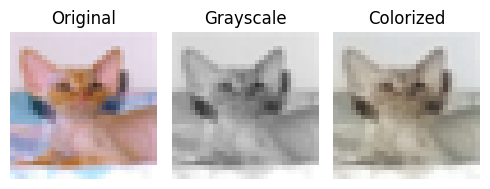

EPOCH: 15.250  train_loss: 0.004  (1096.63s - 6094.38s remaining)

EPOCH: 15.255  train_loss: 0.005  (1096.95s - 6093.76s remaining)

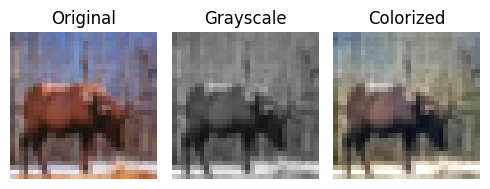

EPOCH: 15.505  train_loss: 0.005  (1113.29s - 6066.84s remaining)

EPOCH: 15.510  train_loss: 0.004  (1113.66s - 6066.51s remaining)

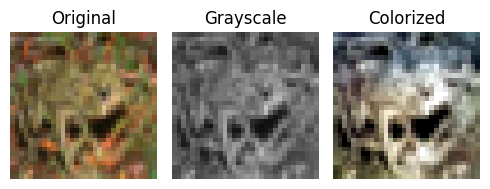

EPOCH: 15.760  train_loss: 0.005  (1129.92s - 6039.53s remaining)

EPOCH: 15.765  train_loss: 0.005  (1130.25s - 6038.96s remaining)

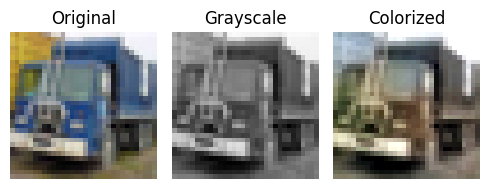

EPOCH: 16.000  val_loss: 0.003  (1152.54s - 6050.83s remaining)

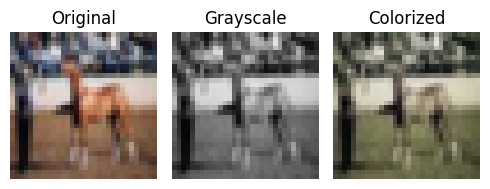

EPOCH: 16.255  train_loss: 0.004  (1169.05s - 6022.86s remaining)

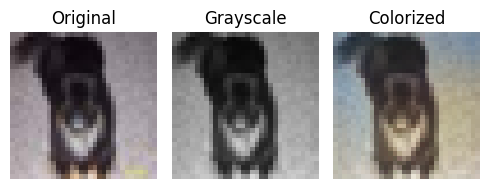

EPOCH: 16.505  train_loss: 0.004  (1185.48s - 5997.01s remaining)

EPOCH: 16.510  train_loss: 0.004  (1185.80s - 5996.41s remaining)

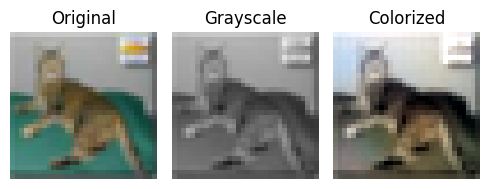

EPOCH: 16.760  train_loss: 0.005  (1202.04s - 5969.95s remaining)

EPOCH: 16.765  train_loss: 0.005  (1202.37s - 5969.40s remaining)

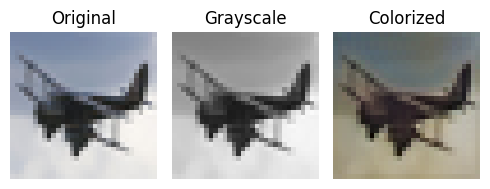

EPOCH: 17.000  val_loss: 0.003  (1224.45s - 5978.21s remaining)

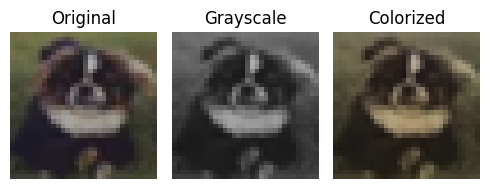

EPOCH: 17.250  train_loss: 0.004  (1240.61s - 5951.34s remaining)

EPOCH: 17.255  train_loss: 0.005  (1240.97s - 5950.94s remaining)

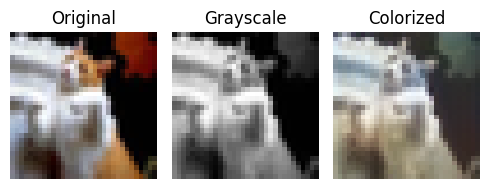

EPOCH: 17.510  train_loss: 0.004  (1258.12s - 5926.94s remaining)

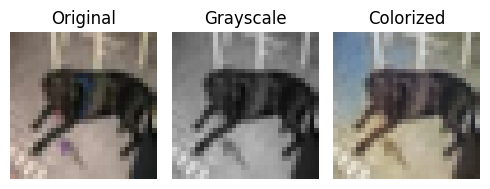

EPOCH: 17.765  train_loss: 0.004  (1274.78s - 5900.90s remaining)

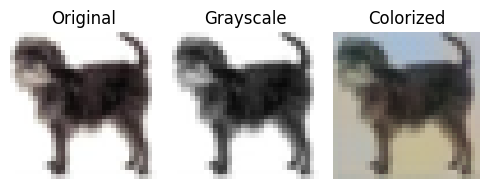

EPOCH: 17.950  val_loss: 0.005  (1296.80s - 5927.73s remaining)

EPOCH: 18.000  val_loss: 0.003  (1297.00s - 5908.55s remaining)

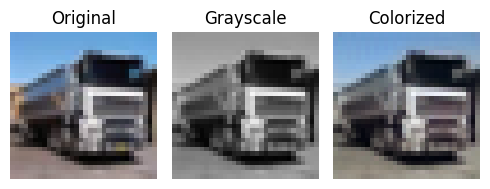

EPOCH: 18.250  train_loss: 0.004  (1313.24s - 5882.59s remaining)

EPOCH: 18.255  train_loss: 0.004  (1313.56s - 5882.04s remaining)

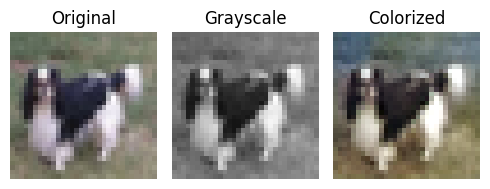

EPOCH: 18.505  train_loss: 0.006  (1330.03s - 5857.35s remaining)

EPOCH: 18.510  train_loss: 0.004  (1330.35s - 5856.78s remaining)

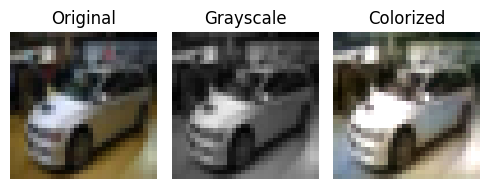

EPOCH: 18.760  train_loss: 0.005  (1346.51s - 5830.96s remaining)

EPOCH: 18.765  train_loss: 0.004  (1346.83s - 5830.39s remaining)

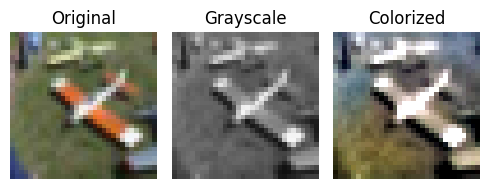

EPOCH: 19.000  val_loss: 0.003  (1369.01s - 5836.31s remaining)

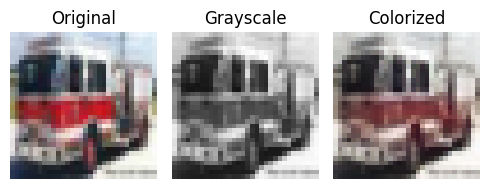

EPOCH: 19.255  train_loss: 0.005  (1385.49s - 5809.97s remaining)

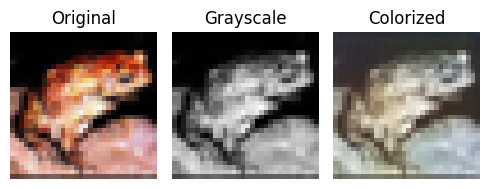

EPOCH: 19.510  train_loss: 0.005  (1402.20s - 5784.82s remaining)

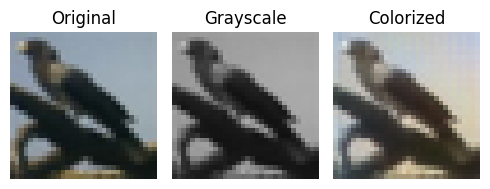

EPOCH: 19.760  train_loss: 0.005  (1418.40s - 5759.65s remaining)

EPOCH: 19.765  train_loss: 0.005  (1418.72s - 5759.10s remaining)

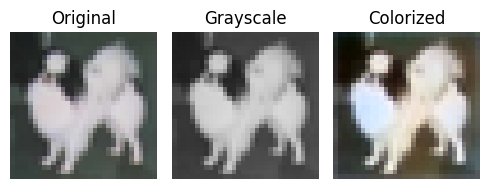

EPOCH: 20.000  val_loss: 0.005  train_loss: 0.004  (1440.95s - 5763.79s remaining)


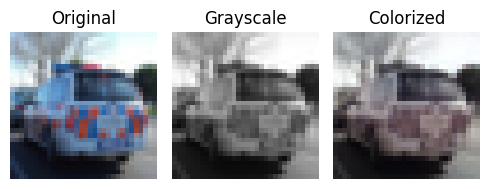

EPOCH: 20.250  train_loss: 0.004  (1457.49s - 5739.99s remaining)

EPOCH: 20.255  train_loss: 0.004  (1457.82s - 5739.47s remaining)

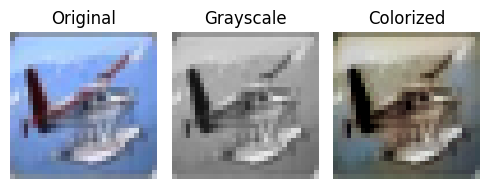

EPOCH: 20.505  train_loss: 0.004  (1474.28s - 5715.54s remaining)

EPOCH: 20.510  train_loss: 0.004  (1474.60s - 5715.00s remaining)

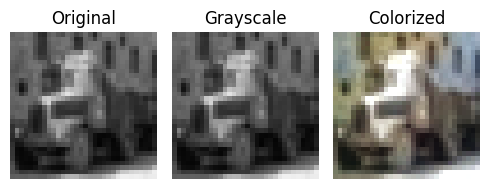

EPOCH: 20.765  train_loss: 0.003  (1491.19s - 5689.95s remaining)

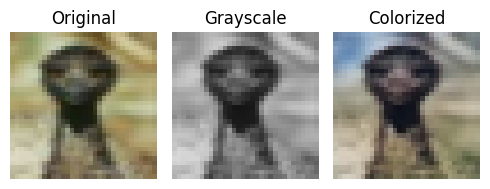

EPOCH: 21.000  val_loss: 0.003  (1513.56s - 5693.86s remaining)

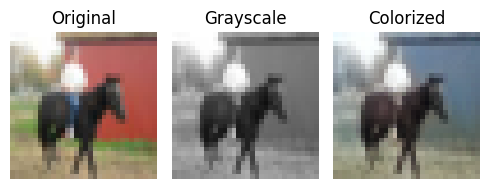

EPOCH: 21.250  train_loss: 0.004  (1529.82s - 5669.35s remaining)

EPOCH: 21.255  train_loss: 0.004  (1530.15s - 5668.82s remaining)

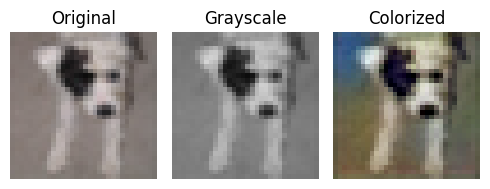

EPOCH: 21.505  train_loss: 0.004  (1546.60s - 5645.17s remaining)

EPOCH: 21.510  train_loss: 0.004  (1546.91s - 5644.62s remaining)

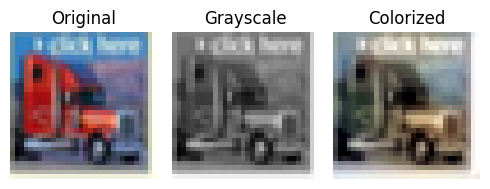

EPOCH: 21.765  train_loss: 0.004  (1563.39s - 5619.57s remaining)

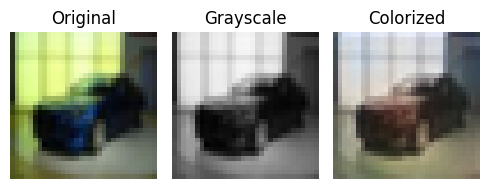

EPOCH: 22.000  val_loss: 0.003  (1585.56s - 5621.52s remaining)

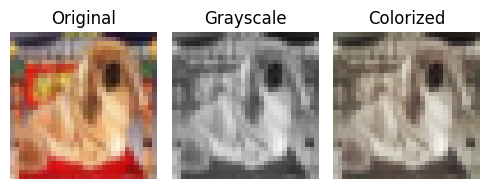

EPOCH: 22.250  train_loss: 0.005  (1601.66s - 5596.81s remaining)

EPOCH: 22.255  train_loss: 0.004  (1601.98s - 5596.28s remaining)

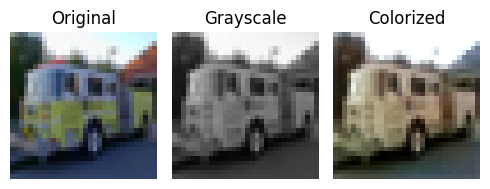

EPOCH: 22.510  train_loss: 0.004  (1618.57s - 5571.80s remaining)

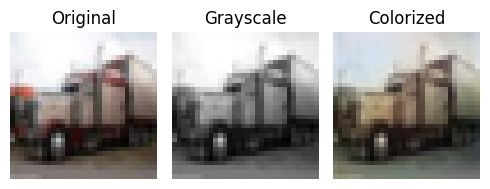

EPOCH: 22.760  train_loss: 0.004  (1634.69s - 5547.55s remaining)

EPOCH: 22.765  train_loss: 0.004  (1635.01s - 5547.02s remaining)

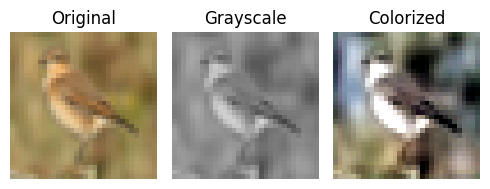

EPOCH: 23.000  val_loss: 0.003  (1657.49s - 5548.98s remaining)

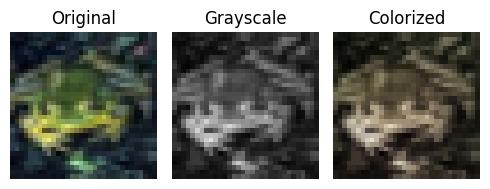

EPOCH: 23.255  train_loss: 0.004  (1673.97s - 5524.31s remaining)

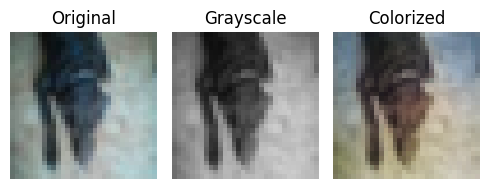

EPOCH: 23.505  train_loss: 0.004  (1690.19s - 5500.54s remaining)

EPOCH: 23.510  train_loss: 0.004  (1690.57s - 5500.23s remaining)

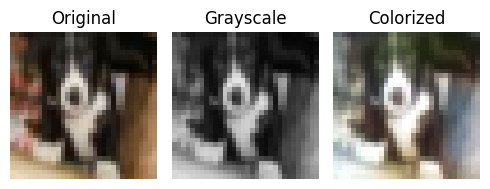

EPOCH: 23.760  train_loss: 0.004  (1706.76s - 5476.50s remaining)

EPOCH: 23.765  train_loss: 0.004  (1707.08s - 5475.99s remaining)

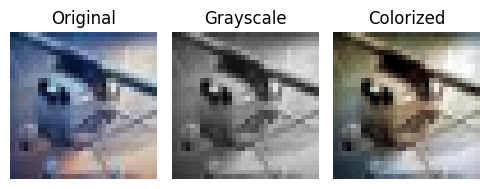

EPOCH: 24.000  val_loss: 0.003  (1729.57s - 5476.96s remaining)

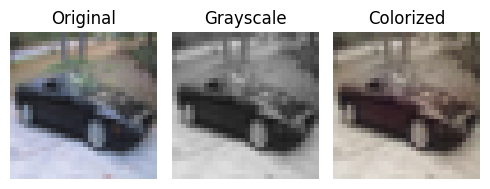

EPOCH: 24.250  train_loss: 0.004  (1745.85s - 5453.54s remaining)

EPOCH: 24.255  train_loss: 0.004  (1746.18s - 5453.03s remaining)

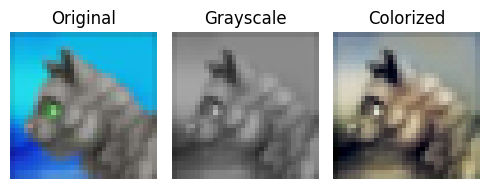

EPOCH: 24.505  train_loss: 0.004  (1762.57s - 5430.09s remaining)

EPOCH: 24.510  train_loss: 0.004  (1762.92s - 5429.68s remaining)

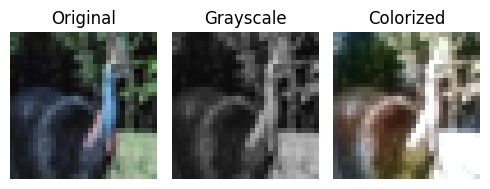

EPOCH: 24.760  train_loss: 0.004  (1779.11s - 5406.24s remaining)

EPOCH: 24.765  train_loss: 0.004  (1779.43s - 5405.74s remaining)

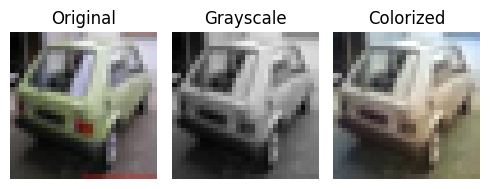

EPOCH: 25.000  val_loss: 0.005  train_loss: 0.004  (1801.56s - 5404.68s remaining)


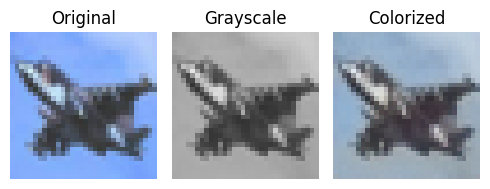

EPOCH: 25.250  train_loss: 0.004  (1817.72s - 5381.16s remaining)

EPOCH: 25.255  train_loss: 0.004  (1818.04s - 5380.66s remaining)

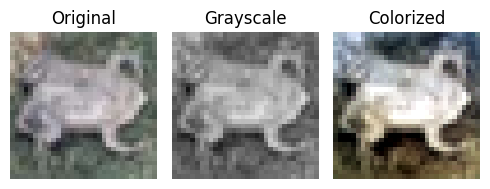

EPOCH: 25.505  train_loss: 0.004  (1834.25s - 5357.46s remaining)

EPOCH: 25.510  train_loss: 0.004  (1834.61s - 5357.05s remaining)

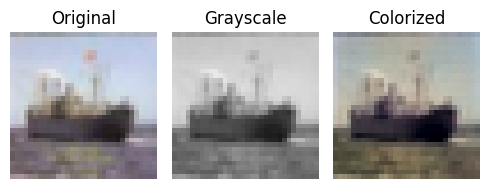

EPOCH: 25.765  train_loss: 0.003  (1851.56s - 5334.69s remaining)

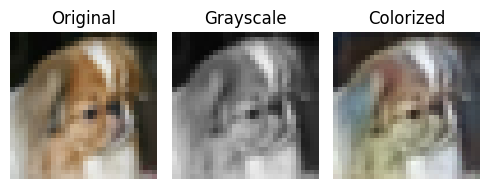

EPOCH: 26.000  val_loss: 0.003  (1873.91s - 5333.42s remaining)

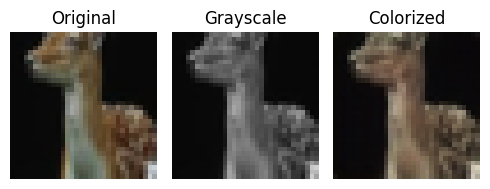

EPOCH: 26.250  train_loss: 0.004  (1890.09s - 5310.24s remaining)

EPOCH: 26.255  train_loss: 0.004  (1890.42s - 5309.78s remaining)

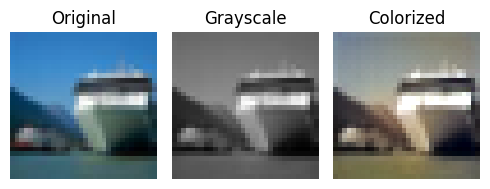

EPOCH: 26.510  train_loss: 0.004  (1907.09s - 5286.72s remaining)

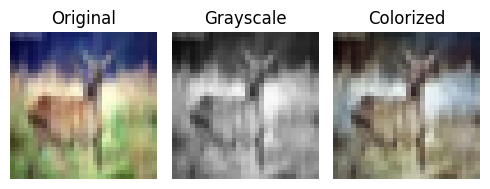

EPOCH: 26.765  train_loss: 0.004  (1923.84s - 5263.99s remaining)

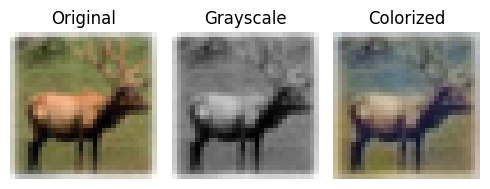

EPOCH: 27.000  val_loss: 0.003  (1946.13s - 5261.76s remaining)

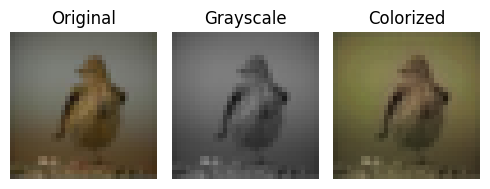

EPOCH: 27.250  train_loss: 0.004  (1962.28s - 5238.75s remaining)

EPOCH: 27.255  train_loss: 0.003  (1962.60s - 5238.25s remaining)

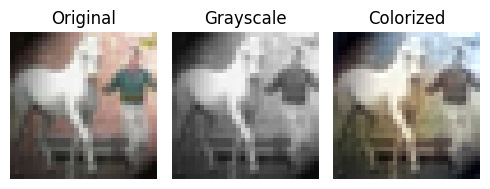

EPOCH: 27.505  train_loss: 0.004  (1978.73s - 5215.32s remaining)

EPOCH: 27.510  train_loss: 0.004  (1979.09s - 5214.93s remaining)

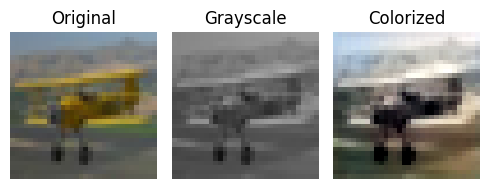

EPOCH: 27.760  train_loss: 0.004  (1995.50s - 5192.85s remaining)

EPOCH: 27.765  train_loss: 0.004  (1995.82s - 5192.36s remaining)

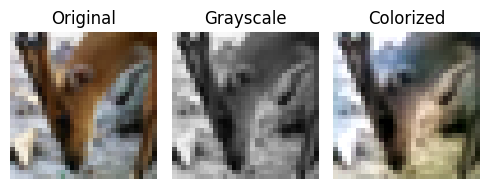

EPOCH: 28.000  val_loss: 0.003  (2018.10s - 5189.41s remaining)

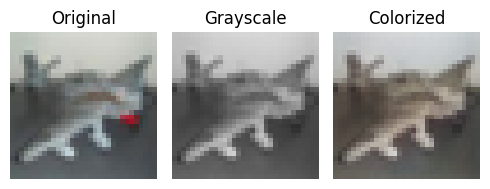

EPOCH: 28.250  train_loss: 0.004  (2034.22s - 5166.55s remaining)

EPOCH: 28.255  train_loss: 0.004  (2034.54s - 5166.06s remaining)

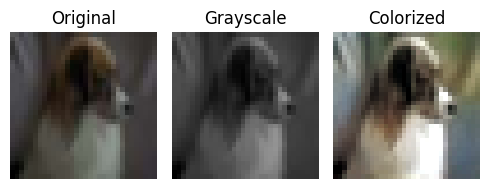

EPOCH: 28.505  train_loss: 0.004  (2051.02s - 5144.25s remaining)

EPOCH: 28.510  train_loss: 0.004  (2051.36s - 5143.81s remaining)

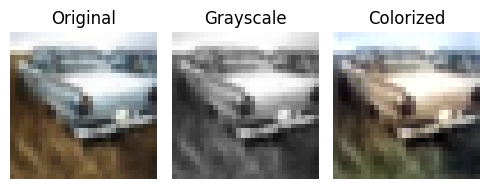

EPOCH: 28.760  train_loss: 0.005  (2067.80s - 5122.00s remaining)

EPOCH: 28.765  train_loss: 0.004  (2068.12s - 5121.51s remaining)

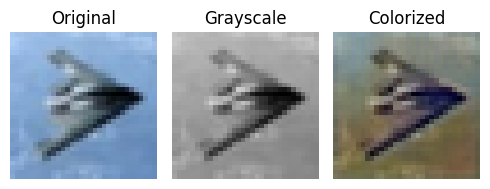

EPOCH: 29.000  val_loss: 0.003  (2090.37s - 5117.81s remaining)

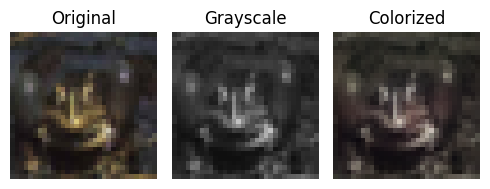

EPOCH: 29.250  train_loss: 0.004  (2106.56s - 5095.35s remaining)

EPOCH: 29.255  train_loss: 0.004  (2106.88s - 5094.86s remaining)

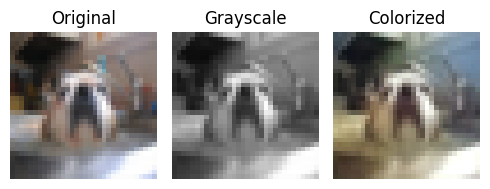

EPOCH: 29.510  train_loss: 0.004  (2123.40s - 5072.08s remaining)

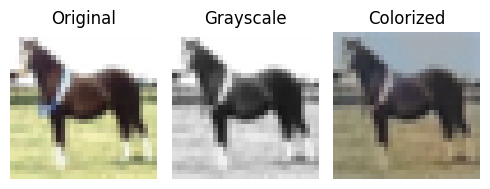

EPOCH: 29.760  train_loss: 0.004  (2139.80s - 5050.34s remaining)

EPOCH: 29.765  train_loss: 0.004  (2140.12s - 5049.86s remaining)

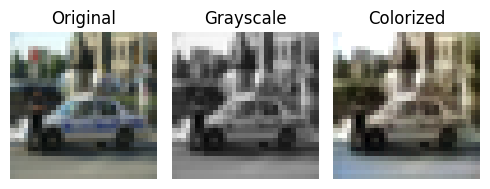

EPOCH: 30.000  val_loss: 0.005  train_loss: 0.004  (2162.39s - 5045.58s remaining)


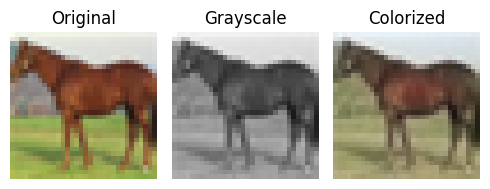

EPOCH: 30.250  train_loss: 0.003  (2178.52s - 5023.20s remaining)

EPOCH: 30.255  train_loss: 0.004  (2178.84s - 5022.72s remaining)

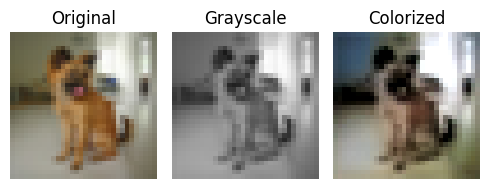

EPOCH: 30.505  train_loss: 0.004  (2194.99s - 5000.50s remaining)

EPOCH: 30.510  train_loss: 0.005  (2195.31s - 5000.02s remaining)

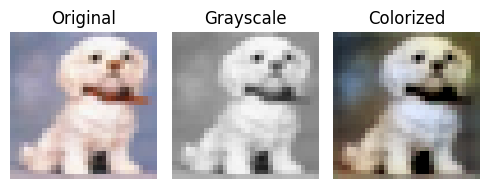

EPOCH: 30.760  train_loss: 0.004  (2211.67s - 4978.36s remaining)

EPOCH: 30.765  train_loss: 0.004  (2211.99s - 4977.89s remaining)

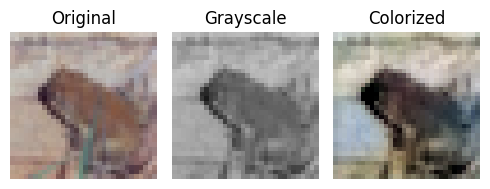

EPOCH: 31.000  val_loss: 0.003  (2234.00s - 4972.45s remaining)

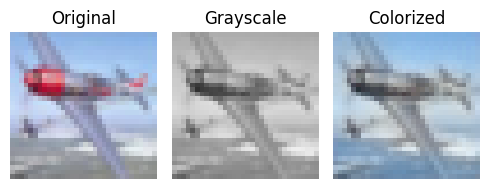

EPOCH: 31.255  train_loss: 0.004  (2250.86s - 4950.72s remaining)

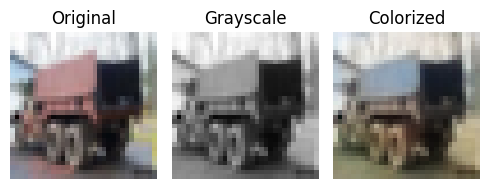

EPOCH: 31.505  train_loss: 0.004  (2267.02s - 4928.70s remaining)

EPOCH: 31.510  train_loss: 0.004  (2267.34s - 4928.24s remaining)

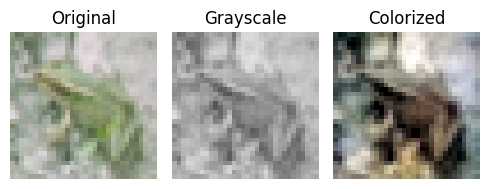

EPOCH: 31.760  train_loss: 0.004  (2283.75s - 4906.86s remaining)

EPOCH: 31.765  train_loss: 0.004  (2284.08s - 4906.40s remaining)

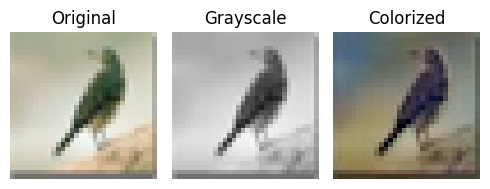

EPOCH: 32.000  val_loss: 0.003  (2306.28s - 4900.84s remaining)

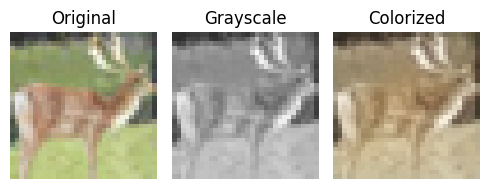

EPOCH: 32.250  train_loss: 0.003  (2322.51s - 4879.06s remaining)

EPOCH: 32.255  train_loss: 0.004  (2322.85s - 4878.64s remaining)

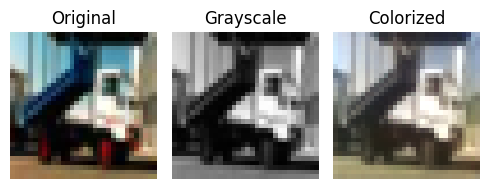

EPOCH: 32.505  train_loss: 0.004  (2339.02s - 4856.84s remaining)

EPOCH: 32.510  train_loss: 0.004  (2339.35s - 4856.38s remaining)

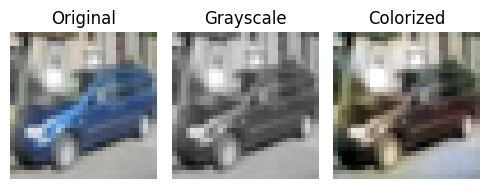

EPOCH: 32.760  train_loss: 0.004  (2355.72s - 4835.08s remaining)

EPOCH: 32.765  train_loss: 0.004  (2356.04s - 4834.62s remaining)

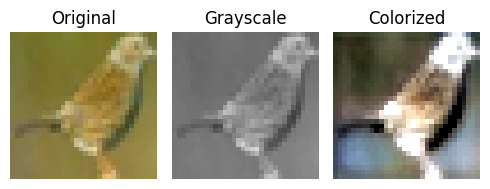

EPOCH: 32.950  val_loss: 0.005  (2377.63s - 4838.24s remaining)

EPOCH: 33.000  val_loss: 0.003  (2377.84s - 4827.73s remaining)

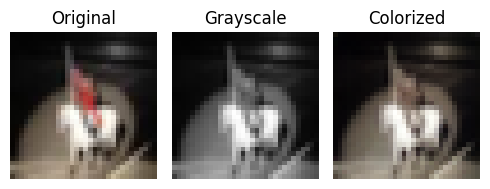

EPOCH: 33.250  train_loss: 0.004  (2394.20s - 4806.40s remaining)

EPOCH: 33.255  train_loss: 0.004  (2394.52s - 4805.93s remaining)

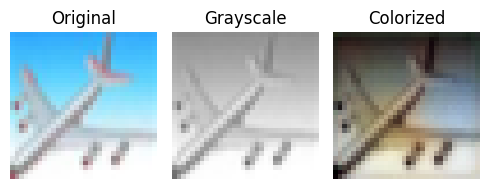

EPOCH: 33.505  train_loss: 0.004  (2410.66s - 4784.24s remaining)

EPOCH: 33.510  train_loss: 0.004  (2410.98s - 4783.78s remaining)

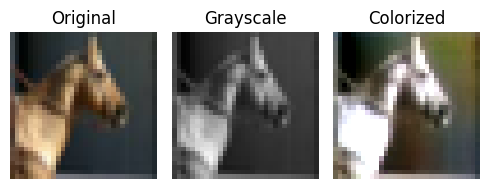

EPOCH: 33.760  train_loss: 0.004  (2427.17s - 4762.27s remaining)

EPOCH: 33.765  train_loss: 0.004  (2427.51s - 4761.85s remaining)

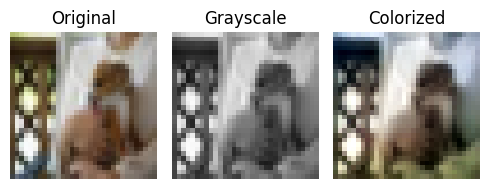

EPOCH: 34.000  val_loss: 0.003  (2449.84s - 4755.58s remaining)

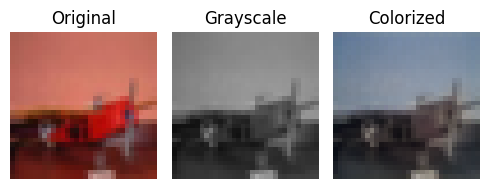

EPOCH: 34.250  train_loss: 0.004  (2466.26s - 4734.50s remaining)

EPOCH: 34.255  train_loss: 0.004  (2466.58s - 4734.04s remaining)

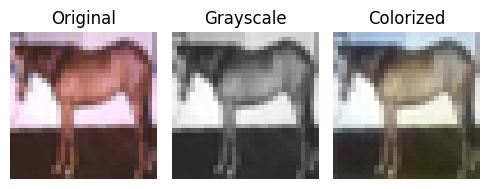

EPOCH: 34.505  train_loss: 0.004  (2482.83s - 4712.72s remaining)

EPOCH: 34.510  train_loss: 0.005  (2483.16s - 4712.27s remaining)

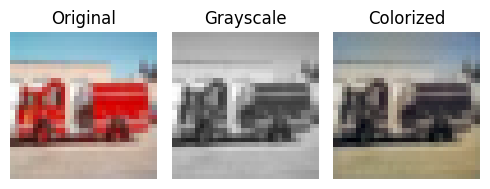

EPOCH: 34.760  train_loss: 0.004  (2499.28s - 4690.78s remaining)

EPOCH: 34.765  train_loss: 0.004  (2499.63s - 4690.38s remaining)

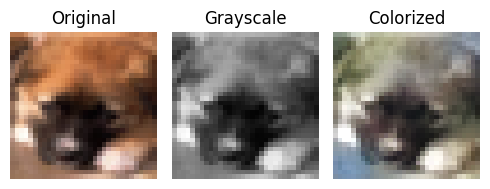

EPOCH: 34.950  val_loss: 0.005  (2521.50s - 4693.10s remaining)

EPOCH: 35.000  val_loss: 0.005  train_loss: 0.004  (2521.71s - 4683.18s remaining)


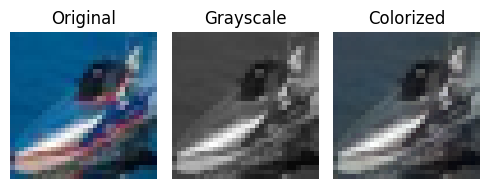

EPOCH: 35.250  train_loss: 0.004  (2538.13s - 4662.23s remaining)

EPOCH: 35.255  train_loss: 0.004  (2538.45s - 4661.78s remaining)

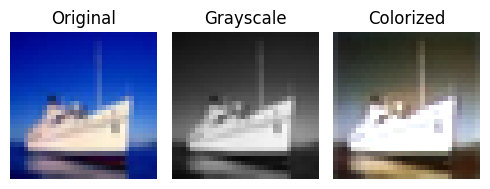

EPOCH: 35.505  train_loss: 0.004  (2554.63s - 4640.48s remaining)

EPOCH: 35.510  train_loss: 0.004  (2554.95s - 4640.03s remaining)

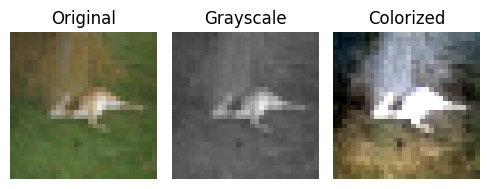

EPOCH: 35.760  train_loss: 0.004  (2571.16s - 4618.84s remaining)

EPOCH: 35.765  train_loss: 0.004  (2571.47s - 4618.38s remaining)

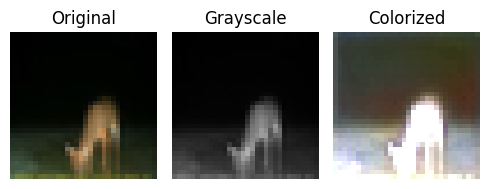

EPOCH: 36.000  val_loss: 0.003  (2593.72s - 4611.05s remaining)

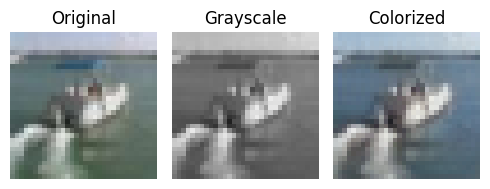

EPOCH: 36.250  train_loss: 0.004  (2609.99s - 4589.99s remaining)

EPOCH: 36.255  train_loss: 0.004  (2610.36s - 4589.62s remaining)

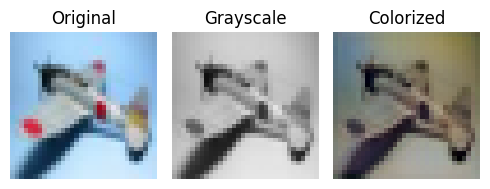

EPOCH: 36.505  train_loss: 0.004  (2626.52s - 4568.42s remaining)

EPOCH: 36.510  train_loss: 0.004  (2626.84s - 4567.97s remaining)

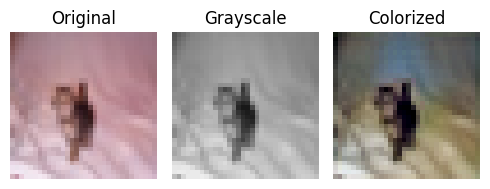

EPOCH: 36.765  train_loss: 0.004  (2643.63s - 4546.93s remaining)

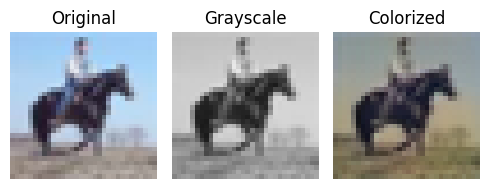

EPOCH: 36.950  val_loss: 0.005  (2665.66s - 4548.57s remaining)

EPOCH: 37.000  val_loss: 0.003  (2665.86s - 4539.17s remaining)

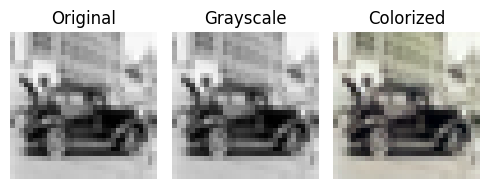

EPOCH: 37.250  train_loss: 0.004  (2682.15s - 4518.26s remaining)

EPOCH: 37.255  train_loss: 0.004  (2682.51s - 4517.88s remaining)

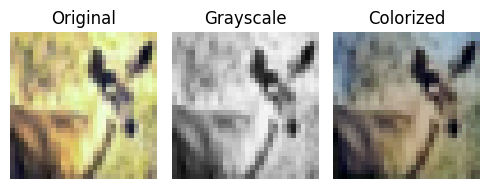

EPOCH: 37.505  train_loss: 0.004  (2698.94s - 4497.26s remaining)

EPOCH: 37.510  train_loss: 0.004  (2699.26s - 4496.81s remaining)

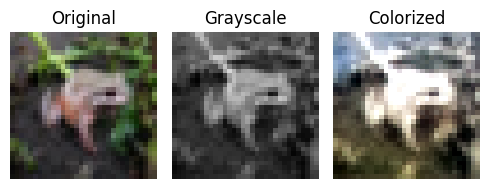

EPOCH: 37.765  train_loss: 0.004  (2715.79s - 4475.44s remaining)

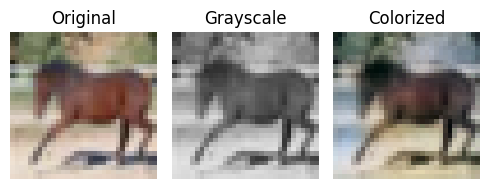

EPOCH: 37.950  val_loss: 0.005  (2737.82s - 4476.45s remaining)

EPOCH: 38.000  val_loss: 0.003  (2738.03s - 4467.31s remaining)

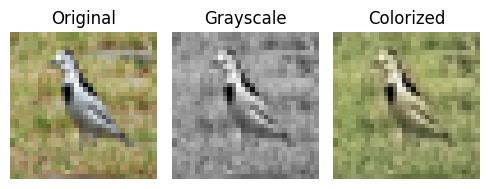

EPOCH: 38.255  train_loss: 0.004  (2754.63s - 4446.06s remaining)

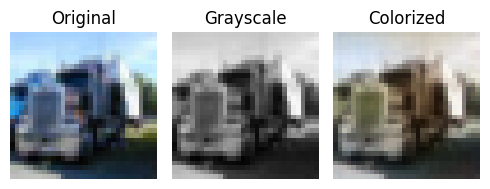

EPOCH: 38.505  train_loss: 0.004  (2771.01s - 4425.46s remaining)

EPOCH: 38.510  train_loss: 0.004  (2771.32s - 4425.01s remaining)

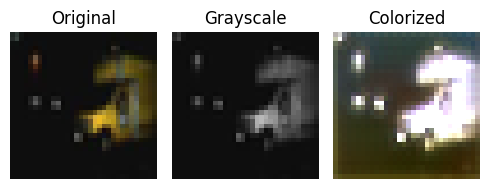

EPOCH: 38.760  train_loss: 0.004  (2787.53s - 4404.21s remaining)

EPOCH: 38.765  train_loss: 0.004  (2787.86s - 4403.77s remaining)

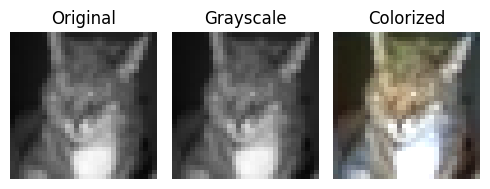

EPOCH: 39.000  val_loss: 0.003  (2810.24s - 4395.50s remaining)

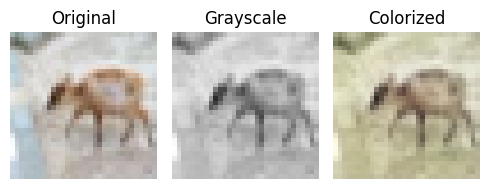

EPOCH: 39.250  train_loss: 0.004  (2826.40s - 4374.62s remaining)

EPOCH: 39.255  train_loss: 0.004  (2826.72s - 4374.17s remaining)

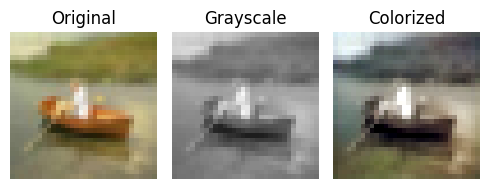

EPOCH: 39.505  train_loss: 0.004  (2843.46s - 4354.25s remaining)

EPOCH: 39.510  train_loss: 0.004  (2843.79s - 4353.82s remaining)

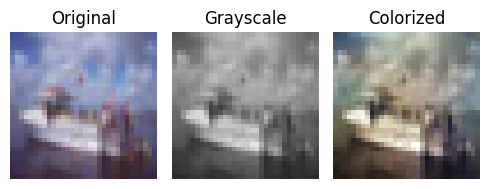

EPOCH: 39.760  train_loss: 0.004  (2859.97s - 4333.08s remaining)

EPOCH: 39.765  train_loss: 0.004  (2860.29s - 4332.64s remaining)

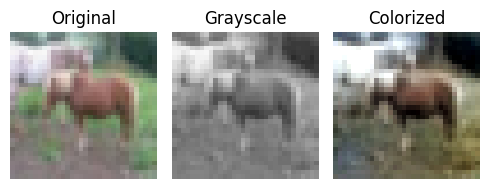

EPOCH: 40.000  val_loss: 0.005  train_loss: 0.004  (2882.67s - 4324.00s remaining)


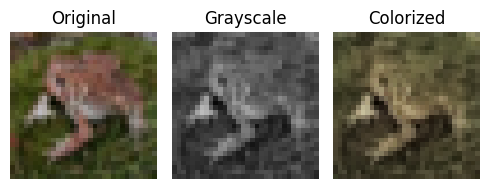

EPOCH: 40.250  train_loss: 0.005  (2898.89s - 4303.32s remaining)

EPOCH: 40.255  train_loss: 0.004  (2899.21s - 4302.88s remaining)

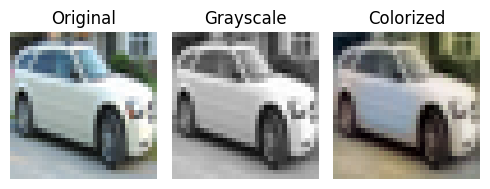

EPOCH: 40.505  train_loss: 0.005  (2915.64s - 4282.56s remaining)

EPOCH: 40.510  train_loss: 0.003  (2915.96s - 4282.13s remaining)

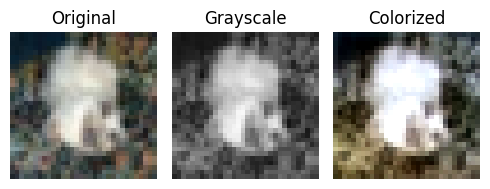

EPOCH: 40.760  train_loss: 0.004  (2932.13s - 4261.48s remaining)

EPOCH: 40.765  train_loss: 0.004  (2932.45s - 4261.04s remaining)

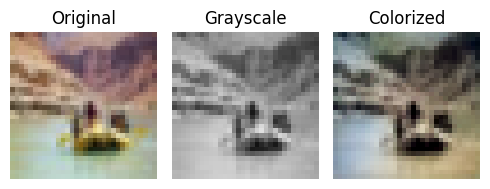

EPOCH: 41.000  val_loss: 0.003  (2954.81s - 4252.05s remaining)

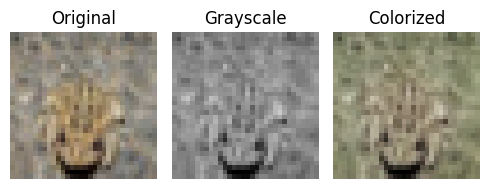

EPOCH: 41.250  train_loss: 0.004  (2970.89s - 4231.26s remaining)

EPOCH: 41.255  train_loss: 0.003  (2971.22s - 4230.84s remaining)

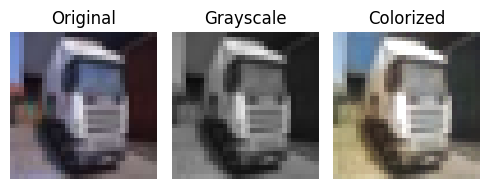

EPOCH: 41.510  train_loss: 0.004  (2987.98s - 4210.20s remaining)

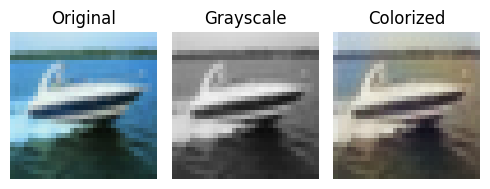

EPOCH: 41.760  train_loss: 0.003  (3004.04s - 4189.50s remaining)

EPOCH: 41.765  train_loss: 0.004  (3004.35s - 4189.06s remaining)

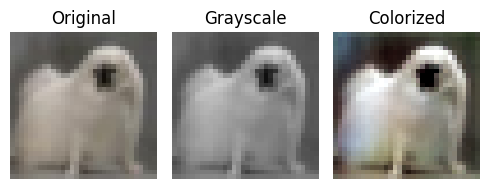

EPOCH: 41.950  val_loss: 0.005  (3026.48s - 4188.01s remaining)

EPOCH: 42.000  val_loss: 0.003  (3026.69s - 4179.72s remaining)

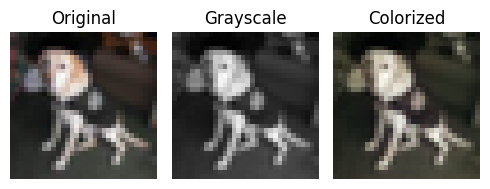

EPOCH: 42.250  train_loss: 0.004  (3043.14s - 4159.56s remaining)

EPOCH: 42.255  train_loss: 0.004  (3043.46s - 4159.12s remaining)

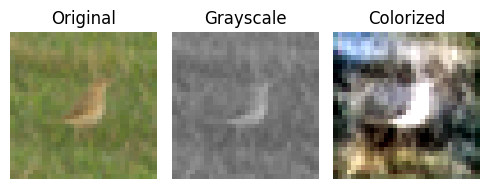

EPOCH: 42.505  train_loss: 0.003  (3059.88s - 4138.97s remaining)

EPOCH: 42.510  train_loss: 0.004  (3060.20s - 4138.54s remaining)

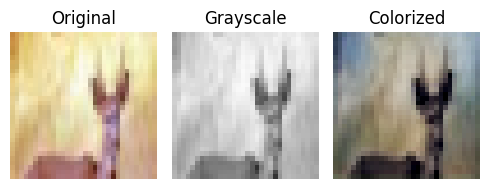

EPOCH: 42.760  train_loss: 0.004  (3076.36s - 4118.09s remaining)

EPOCH: 42.765  train_loss: 0.004  (3076.68s - 4117.66s remaining)

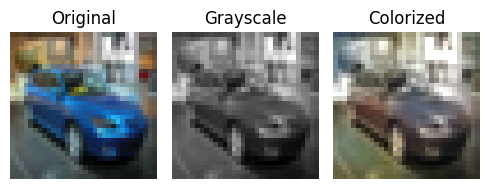

EPOCH: 43.000  val_loss: 0.003  (3099.07s - 4108.06s remaining)

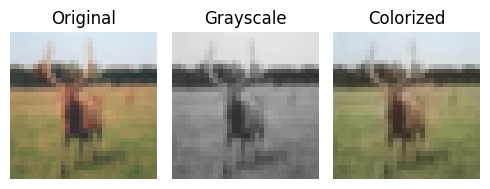

EPOCH: 43.250  train_loss: 0.004  (3115.29s - 4087.69s remaining)

EPOCH: 43.255  train_loss: 0.004  (3115.60s - 4087.26s remaining)

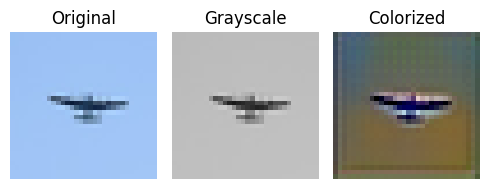

EPOCH: 43.510  train_loss: 0.004  (3132.28s - 4066.67s remaining)

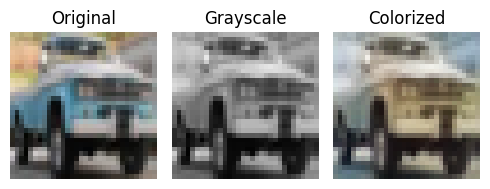

EPOCH: 43.760  train_loss: 0.004  (3148.47s - 4046.36s remaining)

EPOCH: 43.765  train_loss: 0.004  (3148.80s - 4045.94s remaining)

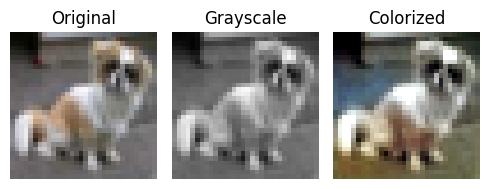

EPOCH: 44.000  val_loss: 0.003  (3171.06s - 4035.90s remaining)

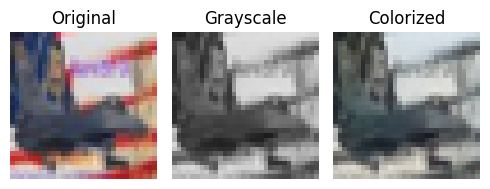

EPOCH: 44.255  train_loss: 0.004  (3187.49s - 4015.05s remaining)

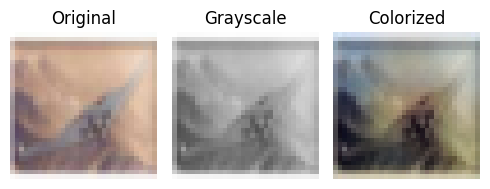

EPOCH: 44.505  train_loss: 0.004  (3203.67s - 3994.76s remaining)

EPOCH: 44.510  train_loss: 0.004  (3204.02s - 3994.37s remaining)

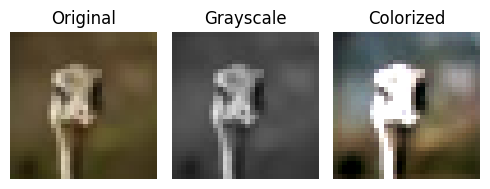

EPOCH: 44.760  train_loss: 0.004  (3220.35s - 3974.32s remaining)

EPOCH: 44.765  train_loss: 0.004  (3220.67s - 3973.89s remaining)

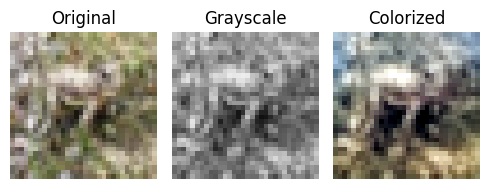

EPOCH: 45.000  val_loss: 0.005  train_loss: 0.004  (3243.24s - 3963.97s remaining)


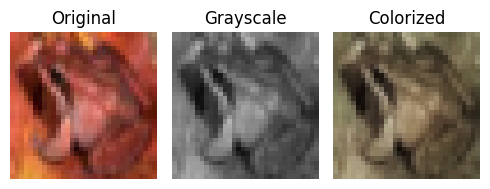

EPOCH: 45.255  train_loss: 0.004  (3259.73s - 3943.29s remaining)

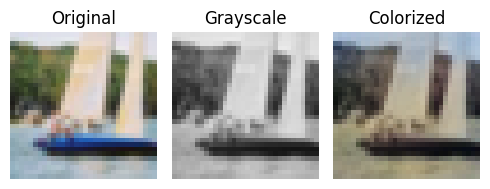

EPOCH: 45.505  train_loss: 0.004  (3275.93s - 3923.11s remaining)

EPOCH: 45.510  train_loss: 0.004  (3276.29s - 3922.74s remaining)

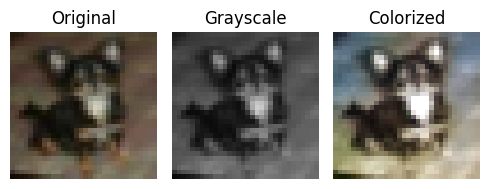

EPOCH: 45.760  train_loss: 0.004  (3292.74s - 3902.90s remaining)

EPOCH: 45.765  train_loss: 0.003  (3293.06s - 3902.48s remaining)

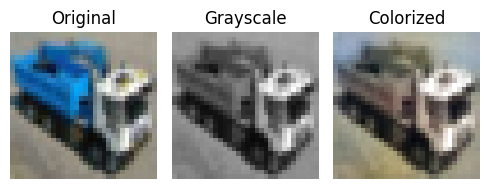

EPOCH: 46.000  val_loss: 0.003  (3315.40s - 3891.99s remaining)

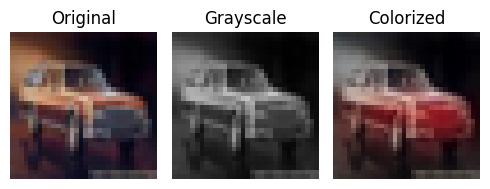

EPOCH: 46.250  train_loss: 0.004  (3331.60s - 3871.86s remaining)

EPOCH: 46.255  train_loss: 0.004  (3331.93s - 3871.45s remaining)

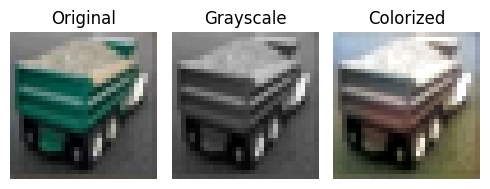

EPOCH: 46.505  train_loss: 0.004  (3348.10s - 3851.33s remaining)

EPOCH: 46.510  train_loss: 0.004  (3348.43s - 3850.91s remaining)

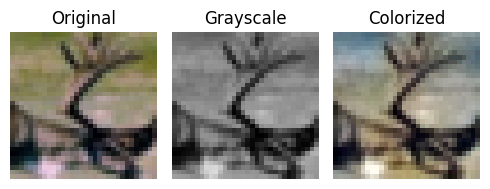

EPOCH: 46.760  train_loss: 0.004  (3364.86s - 3831.13s remaining)

EPOCH: 46.765  train_loss: 0.004  (3365.18s - 3830.71s remaining)

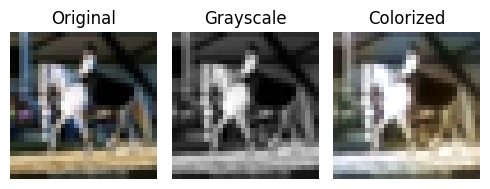

EPOCH: 46.950  val_loss: 0.005  (3387.24s - 3827.33s remaining)

EPOCH: 47.000  val_loss: 0.003  (3387.50s - 3819.94s remaining)

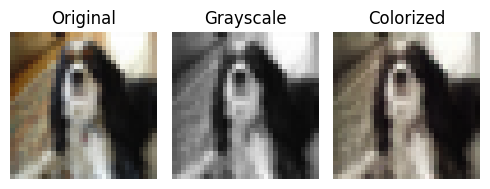

EPOCH: 47.250  train_loss: 0.003  (3403.62s - 3799.81s remaining)

EPOCH: 47.255  train_loss: 0.004  (3403.94s - 3799.39s remaining)

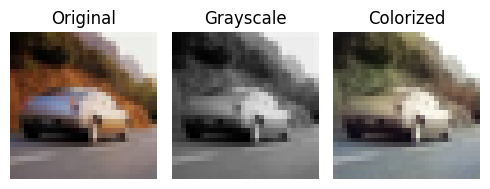

EPOCH: 47.505  train_loss: 0.004  (3420.10s - 3779.34s remaining)

EPOCH: 47.510  train_loss: 0.004  (3420.42s - 3778.92s remaining)

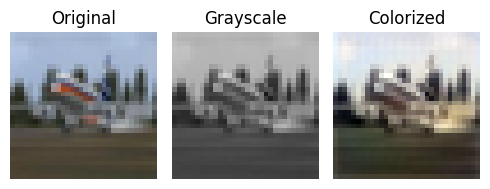

EPOCH: 47.760  train_loss: 0.004  (3437.09s - 3759.47s remaining)

EPOCH: 47.765  train_loss: 0.004  (3437.41s - 3759.05s remaining)

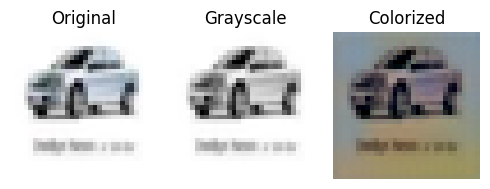

EPOCH: 48.000  val_loss: 0.003  (3459.63s - 3747.93s remaining)

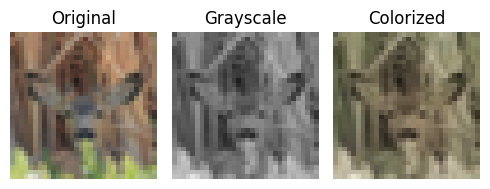

EPOCH: 48.250  train_loss: 0.004  (3476.05s - 3728.20s remaining)

EPOCH: 48.255  train_loss: 0.004  (3476.38s - 3727.79s remaining)

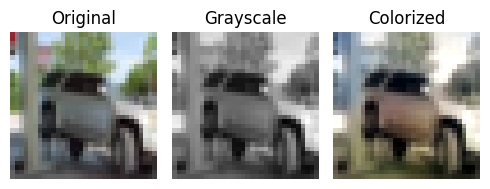

EPOCH: 48.510  train_loss: 0.004  (3492.90s - 3707.44s remaining)

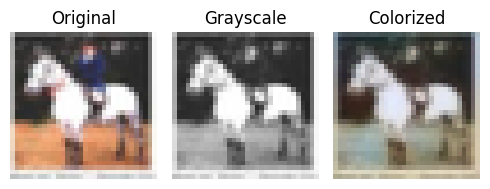

EPOCH: 48.765  train_loss: 0.004  (3509.56s - 3687.28s remaining)

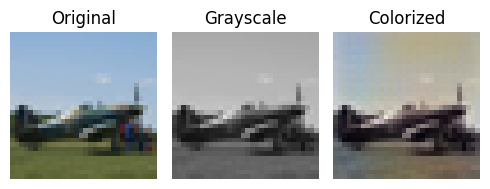

EPOCH: 49.000  val_loss: 0.003  (3531.57s - 3675.71s remaining)

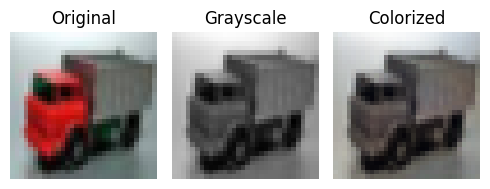

EPOCH: 49.250  train_loss: 0.004  (3547.87s - 3655.93s remaining)

EPOCH: 49.255  train_loss: 0.005  (3548.19s - 3655.51s remaining)

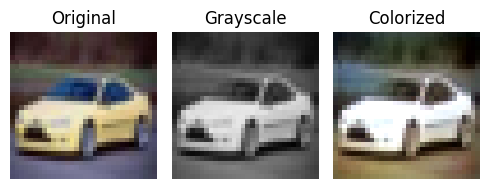

EPOCH: 49.505  train_loss: 0.004  (3564.40s - 3635.67s remaining)

EPOCH: 49.510  train_loss: 0.004  (3564.73s - 3635.27s remaining)

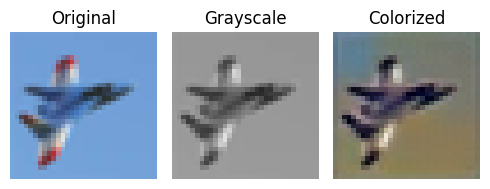

EPOCH: 49.760  train_loss: 0.004  (3580.92s - 3615.44s remaining)

EPOCH: 49.765  train_loss: 0.004  (3581.26s - 3615.04s remaining)

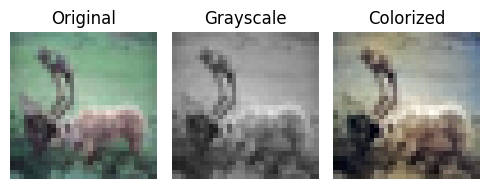

EPOCH: 49.950  val_loss: 0.005  (3603.26s - 3610.47s remaining)

EPOCH: 50.000  val_loss: 0.005  train_loss: 0.004  (3603.46s - 3603.46s remaining)


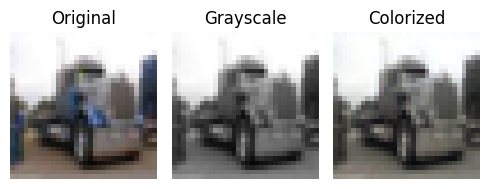

EPOCH: 50.250  train_loss: 0.004  (3619.81s - 3583.79s remaining)

EPOCH: 50.255  train_loss: 0.003  (3620.13s - 3583.37s remaining)

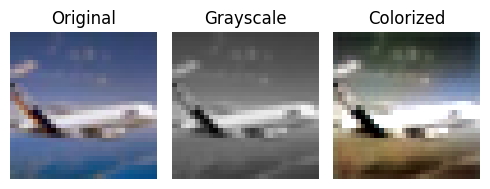

EPOCH: 50.505  train_loss: 0.004  (3636.65s - 3563.91s remaining)

EPOCH: 50.510  train_loss: 0.004  (3636.96s - 3563.49s remaining)

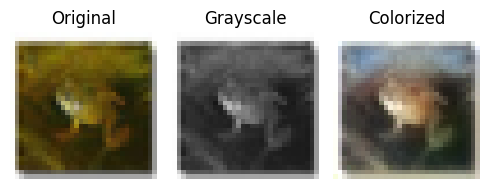

EPOCH: 50.760  train_loss: 0.004  (3653.17s - 3543.74s remaining)

EPOCH: 50.765  train_loss: 0.004  (3653.49s - 3543.33s remaining)

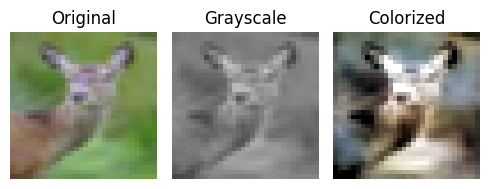

EPOCH: 51.000  val_loss: 0.003  (3675.85s - 3531.70s remaining)

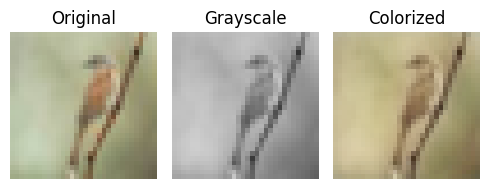

EPOCH: 51.255  train_loss: 0.004  (3692.57s - 3511.73s remaining)

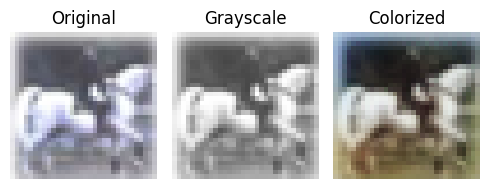

EPOCH: 51.505  train_loss: 0.005  (3708.72s - 3491.97s remaining)

EPOCH: 51.510  train_loss: 0.004  (3709.05s - 3491.56s remaining)

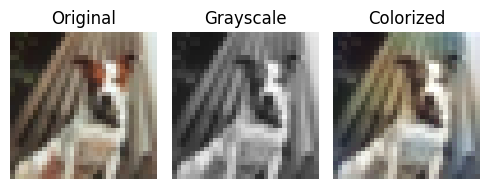

EPOCH: 51.760  train_loss: 0.004  (3725.19s - 3471.83s remaining)

EPOCH: 51.765  train_loss: 0.004  (3725.52s - 3471.43s remaining)

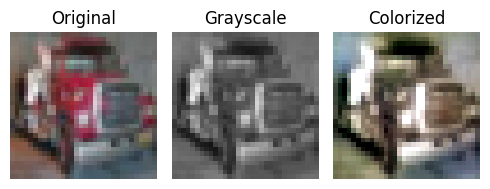

EPOCH: 52.000  val_loss: 0.003  (3747.89s - 3459.59s remaining)

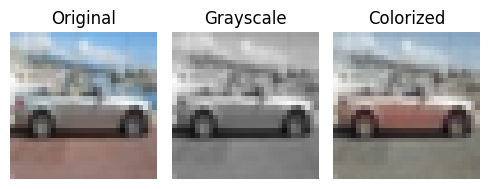

EPOCH: 52.250  train_loss: 0.004  (3764.05s - 3439.87s remaining)

EPOCH: 52.255  train_loss: 0.004  (3764.40s - 3439.49s remaining)

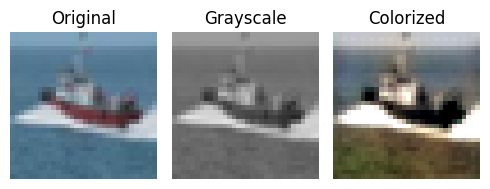

EPOCH: 52.505  train_loss: 0.004  (3780.76s - 3419.99s remaining)

EPOCH: 52.510  train_loss: 0.004  (3781.07s - 3419.57s remaining)

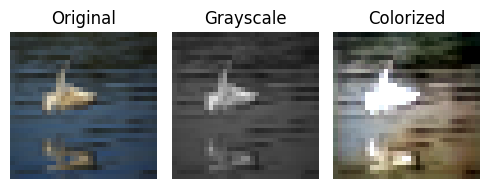

EPOCH: 52.760  train_loss: 0.004  (3797.12s - 3399.82s remaining)

EPOCH: 52.765  train_loss: 0.003  (3797.44s - 3399.41s remaining)

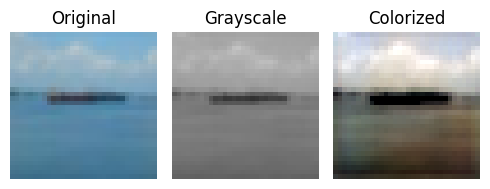

EPOCH: 53.000  val_loss: 0.003  (3819.73s - 3387.30s remaining)

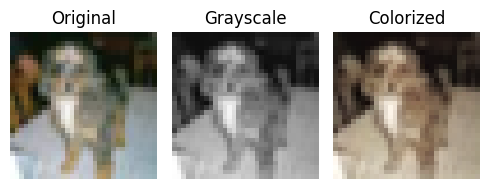

EPOCH: 53.250  train_loss: 0.004  (3836.22s - 3367.95s remaining)

EPOCH: 53.255  train_loss: 0.004  (3836.54s - 3367.54s remaining)

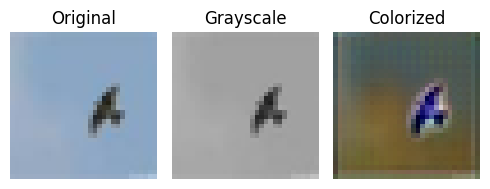

EPOCH: 53.505  train_loss: 0.004  (3853.12s - 3348.29s remaining)

EPOCH: 53.510  train_loss: 0.004  (3853.45s - 3347.89s remaining)

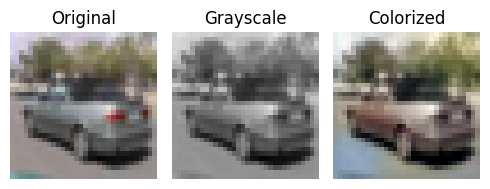

EPOCH: 53.765  train_loss: 0.004  (3870.06s - 3328.00s remaining)

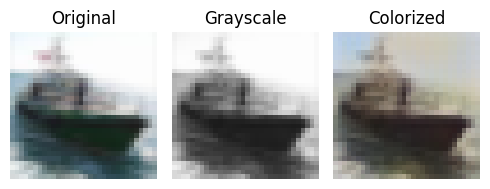

EPOCH: 53.950  val_loss: 0.005  (3892.49s - 3322.51s remaining)

EPOCH: 54.000  val_loss: 0.003  (3892.70s - 3316.01s remaining)

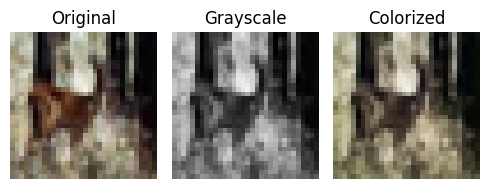

EPOCH: 54.255  train_loss: 0.004  (3909.32s - 3296.12s remaining)

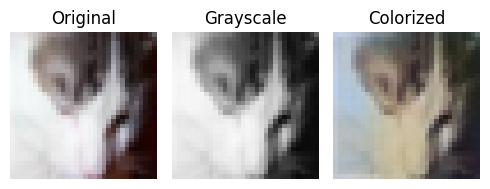

EPOCH: 54.510  train_loss: 0.004  (3926.09s - 3276.39s remaining)

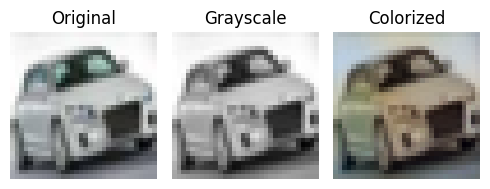

EPOCH: 54.760  train_loss: 0.004  (3942.22s - 3256.84s remaining)

EPOCH: 54.765  train_loss: 0.004  (3942.54s - 3256.43s remaining)

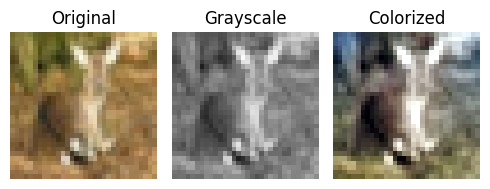

EPOCH: 54.950  val_loss: 0.005  (3964.79s - 3250.48s remaining)

EPOCH: 55.000  val_loss: 0.005  train_loss: 0.004  (3964.99s - 3244.09s remaining)


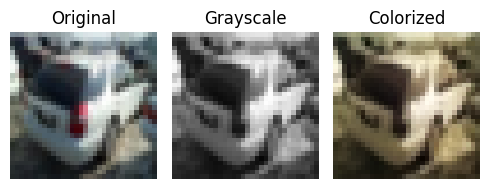

EPOCH: 55.250  train_loss: 0.004  (3981.21s - 3224.60s remaining)

EPOCH: 55.255  train_loss: 0.004  (3981.53s - 3224.19s remaining)

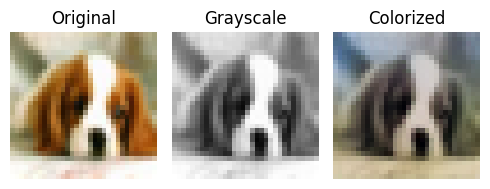

EPOCH: 55.505  train_loss: 0.004  (3997.86s - 3204.83s remaining)

EPOCH: 55.510  train_loss: 0.004  (3998.23s - 3204.46s remaining)

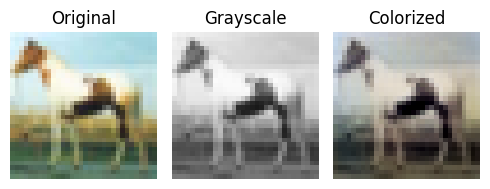

EPOCH: 55.760  train_loss: 0.004  (4014.39s - 3185.00s remaining)

EPOCH: 55.765  train_loss: 0.004  (4014.71s - 3184.59s remaining)

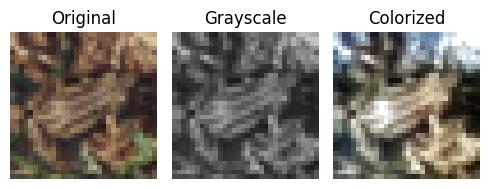

EPOCH: 56.000  val_loss: 0.003  (4037.32s - 3172.18s remaining)

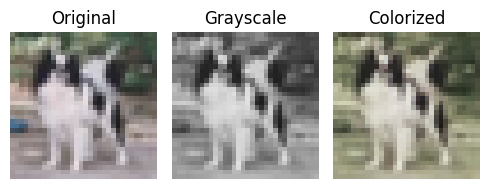

EPOCH: 56.250  train_loss: 0.004  (4053.49s - 3152.71s remaining)

EPOCH: 56.255  train_loss: 0.004  (4053.81s - 3152.31s remaining)

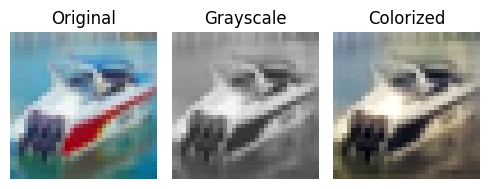

EPOCH: 56.505  train_loss: 0.004  (4070.02s - 3132.90s remaining)

EPOCH: 56.510  train_loss: 0.004  (4070.35s - 3132.51s remaining)

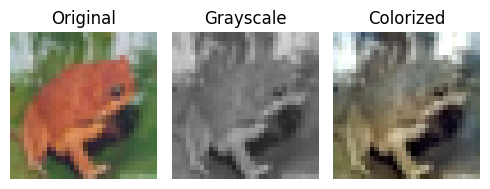

EPOCH: 56.760  train_loss: 0.004  (4086.73s - 3113.26s remaining)

EPOCH: 56.765  train_loss: 0.004  (4087.04s - 3112.85s remaining)

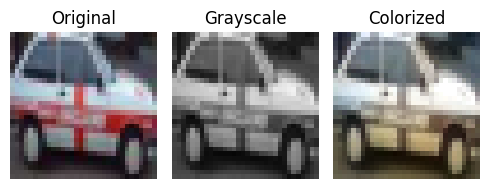

EPOCH: 57.000  val_loss: 0.003  (4109.43s - 3100.10s remaining)

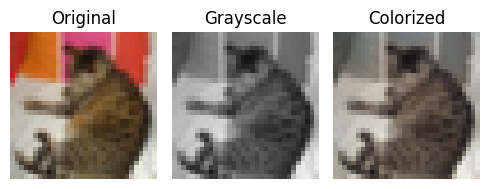

EPOCH: 57.250  train_loss: 0.004  (4125.56s - 3080.66s remaining)

EPOCH: 57.255  train_loss: 0.004  (4125.88s - 3080.25s remaining)

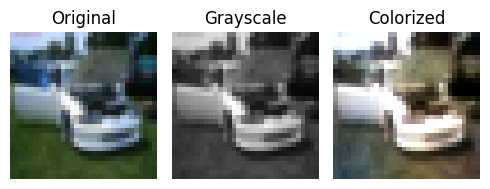

EPOCH: 57.505  train_loss: 0.004  (4142.08s - 3060.90s remaining)

EPOCH: 57.510  train_loss: 0.004  (4142.40s - 3060.50s remaining)

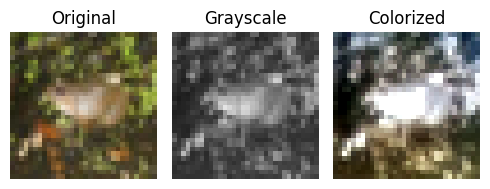

EPOCH: 57.760  train_loss: 0.004  (4158.78s - 3041.30s remaining)

EPOCH: 57.765  train_loss: 0.004  (4159.10s - 3040.89s remaining)

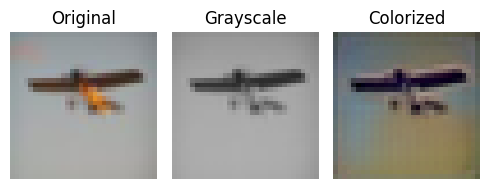

EPOCH: 57.950  val_loss: 0.005  (4181.11s - 3033.92s remaining)

EPOCH: 58.000  val_loss: 0.003  (4181.38s - 3027.89s remaining)

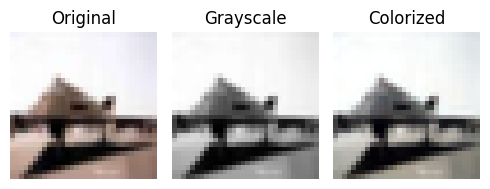

EPOCH: 58.250  train_loss: 0.004  (4197.65s - 3008.62s remaining)

EPOCH: 58.255  train_loss: 0.004  (4197.97s - 3008.21s remaining)

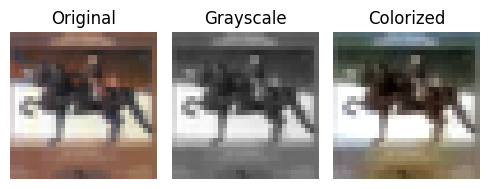

EPOCH: 58.505  train_loss: 0.004  (4214.12s - 2988.88s remaining)

EPOCH: 58.510  train_loss: 0.004  (4214.45s - 2988.48s remaining)

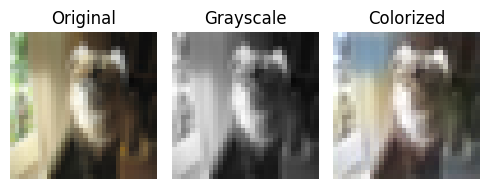

EPOCH: 58.760  train_loss: 0.004  (4231.18s - 2969.58s remaining)

EPOCH: 58.765  train_loss: 0.005  (4231.50s - 2969.18s remaining)

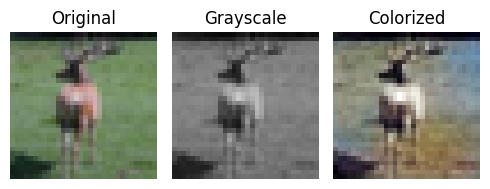

EPOCH: 58.950  val_loss: 0.005  (4253.41s - 2961.87s remaining)

EPOCH: 59.000  val_loss: 0.003  (4253.65s - 2955.93s remaining)

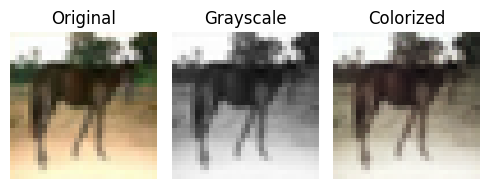

EPOCH: 59.255  train_loss: 0.004  (4270.34s - 2936.37s remaining)

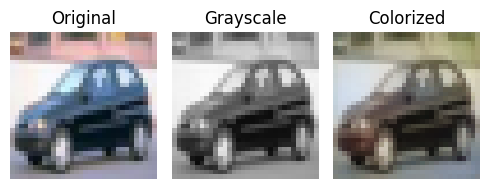

EPOCH: 59.505  train_loss: 0.004  (4286.45s - 2917.05s remaining)

EPOCH: 59.510  train_loss: 0.003  (4286.77s - 2916.65s remaining)

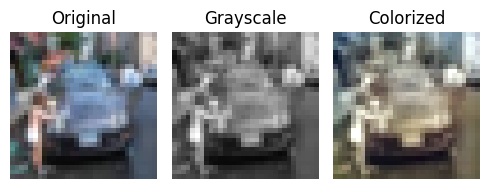

EPOCH: 59.760  train_loss: 0.004  (4303.03s - 2897.46s remaining)

EPOCH: 59.765  train_loss: 0.005  (4303.38s - 2897.08s remaining)

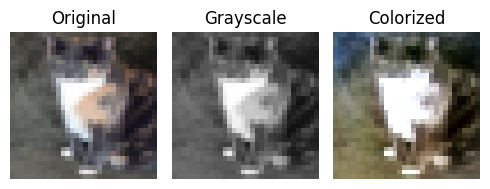

EPOCH: 60.000  val_loss: 0.005  train_loss: 0.004  (4325.61s - 2883.74s remaining)


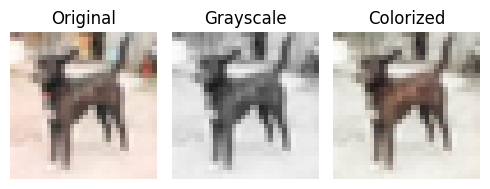

EPOCH: 60.255  train_loss: 0.004  (4342.33s - 2864.25s remaining)

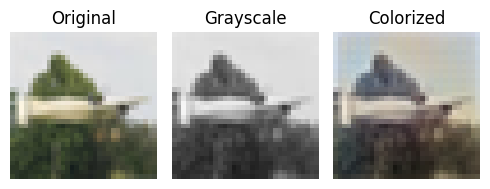

EPOCH: 60.505  train_loss: 0.004  (4358.46s - 2845.00s remaining)

EPOCH: 60.510  train_loss: 0.004  (4358.78s - 2844.60s remaining)

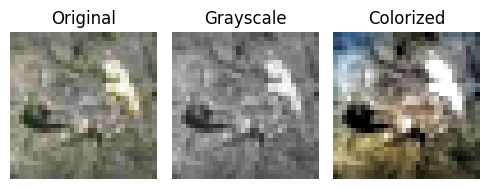

EPOCH: 60.760  train_loss: 0.004  (4374.88s - 2825.36s remaining)

EPOCH: 60.765  train_loss: 0.005  (4375.20s - 2824.96s remaining)

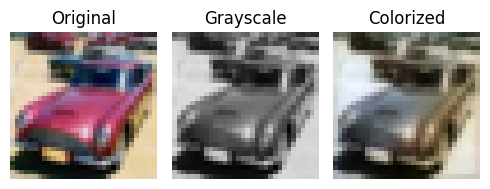

EPOCH: 60.950  val_loss: 0.005  (4397.07s - 2817.16s remaining)

EPOCH: 61.000  val_loss: 0.003  (4397.28s - 2811.38s remaining)

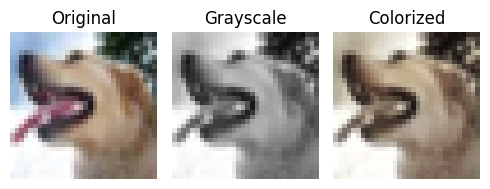

EPOCH: 61.255  train_loss: 0.004  (4413.90s - 2791.87s remaining)

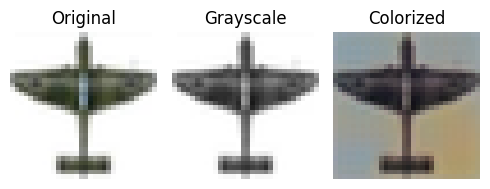

EPOCH: 61.505  train_loss: 0.004  (4430.55s - 2773.00s remaining)

EPOCH: 61.510  train_loss: 0.004  (4430.87s - 2772.60s remaining)

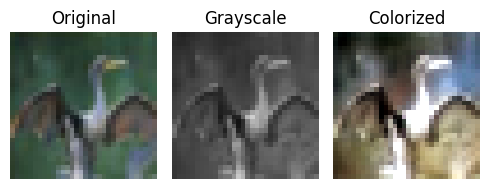

EPOCH: 61.760  train_loss: 0.004  (4447.09s - 2753.48s remaining)

EPOCH: 61.765  train_loss: 0.004  (4447.41s - 2753.09s remaining)

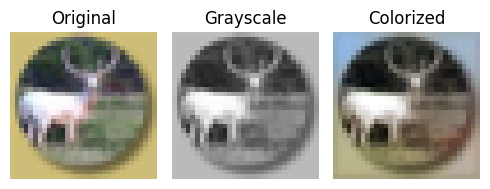

EPOCH: 61.950  val_loss: 0.005  (4469.59s - 2745.25s remaining)

EPOCH: 62.000  val_loss: 0.003  (4469.81s - 2739.56s remaining)

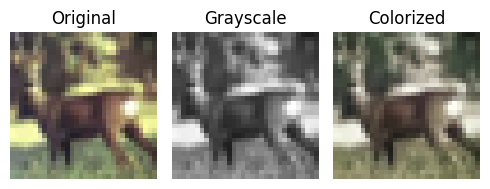

EPOCH: 62.250  train_loss: 0.004  (4486.00s - 2720.43s remaining)

EPOCH: 62.255  train_loss: 0.004  (4486.32s - 2720.03s remaining)

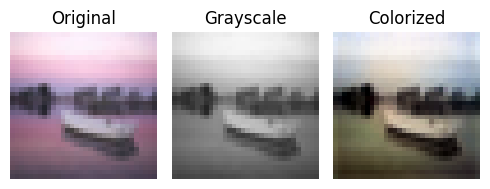

EPOCH: 62.505  train_loss: 0.004  (4502.80s - 2701.09s remaining)

EPOCH: 62.510  train_loss: 0.004  (4503.12s - 2700.70s remaining)

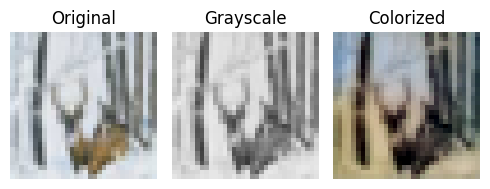

EPOCH: 62.760  train_loss: 0.004  (4519.28s - 2681.59s remaining)

EPOCH: 62.765  train_loss: 0.004  (4519.59s - 2681.19s remaining)

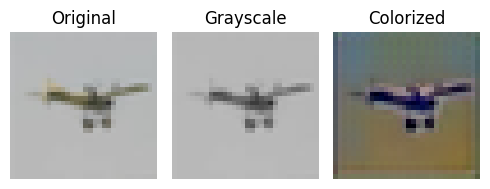

EPOCH: 63.000  val_loss: 0.003  (4541.99s - 2667.52s remaining)

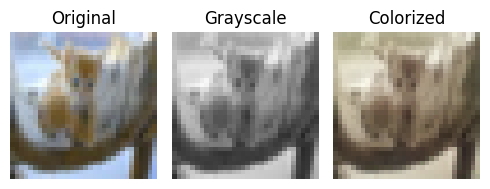

EPOCH: 63.250  train_loss: 0.004  (4558.10s - 2648.39s remaining)

EPOCH: 63.255  train_loss: 0.003  (4558.43s - 2647.99s remaining)

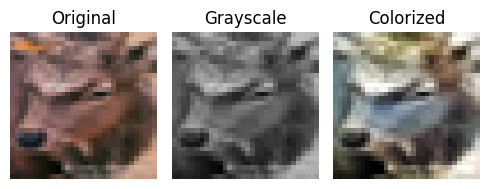

EPOCH: 63.505  train_loss: 0.004  (4574.82s - 2629.04s remaining)

EPOCH: 63.510  train_loss: 0.004  (4575.14s - 2628.65s remaining)

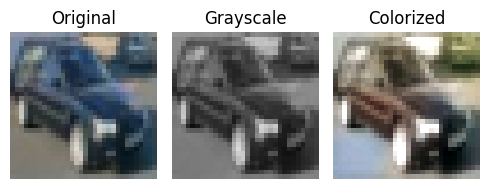

EPOCH: 63.760  train_loss: 0.004  (4591.29s - 2609.58s remaining)

EPOCH: 63.765  train_loss: 0.004  (4591.61s - 2609.19s remaining)

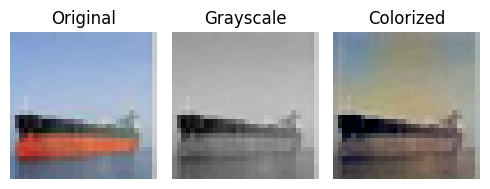

EPOCH: 64.000  val_loss: 0.003  (4614.00s - 2595.37s remaining)

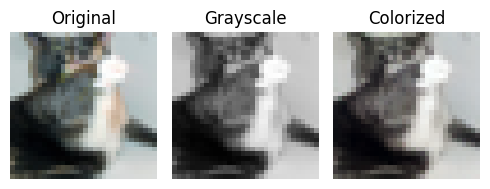

EPOCH: 64.250  train_loss: 0.004  (4630.42s - 2576.46s remaining)

EPOCH: 64.255  train_loss: 0.004  (4630.74s - 2576.07s remaining)

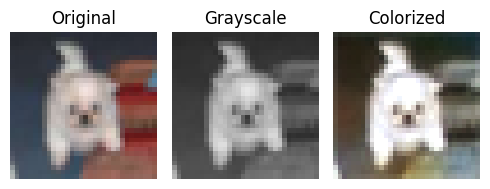

EPOCH: 64.505  train_loss: 0.004  (4647.16s - 2557.17s remaining)

EPOCH: 64.510  train_loss: 0.004  (4647.51s - 2556.79s remaining)

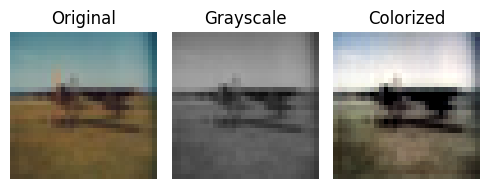

EPOCH: 64.765  train_loss: 0.004  (4664.14s - 2537.46s remaining)

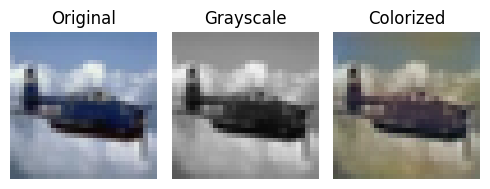

EPOCH: 65.000  val_loss: 0.005  train_loss: 0.004  (4686.67s - 2523.59s remaining)


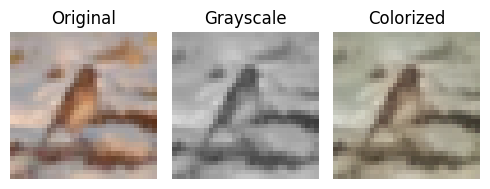

EPOCH: 65.250  train_loss: 0.004  (4702.89s - 2504.60s remaining)

EPOCH: 65.255  train_loss: 0.005  (4703.21s - 2504.21s remaining)

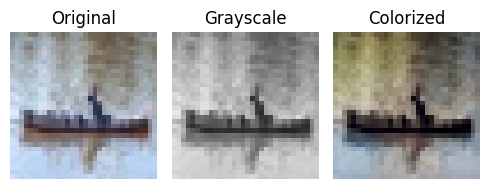

EPOCH: 65.505  train_loss: 0.004  (4719.38s - 2485.22s remaining)

EPOCH: 65.510  train_loss: 0.004  (4719.70s - 2484.83s remaining)

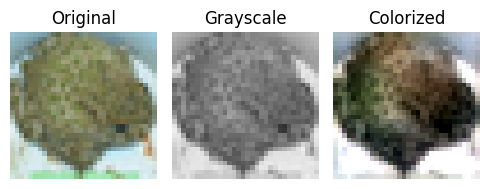

EPOCH: 65.760  train_loss: 0.004  (4736.12s - 2465.99s remaining)

EPOCH: 65.765  train_loss: 0.004  (4736.44s - 2465.59s remaining)

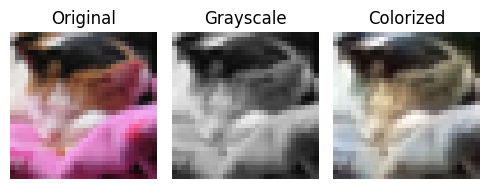

EPOCH: 65.950  val_loss: 0.005  (4758.61s - 2456.87s remaining)

EPOCH: 66.000  val_loss: 0.003  (4758.86s - 2451.53s remaining)

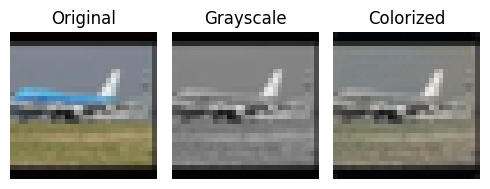

EPOCH: 66.250  train_loss: 0.004  (4775.05s - 2432.57s remaining)

EPOCH: 66.255  train_loss: 0.004  (4775.36s - 2432.18s remaining)

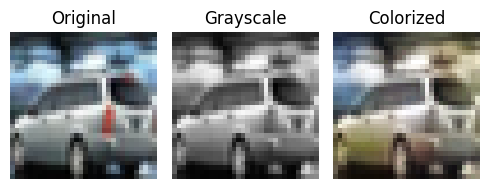

EPOCH: 66.505  train_loss: 0.004  (4791.60s - 2413.26s remaining)

EPOCH: 66.510  train_loss: 0.004  (4791.92s - 2412.87s remaining)

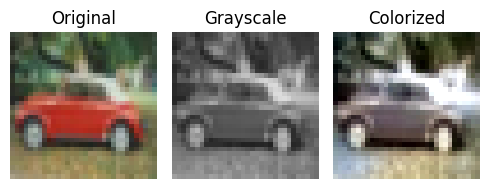

EPOCH: 66.765  train_loss: 0.004  (4808.58s - 2393.63s remaining)

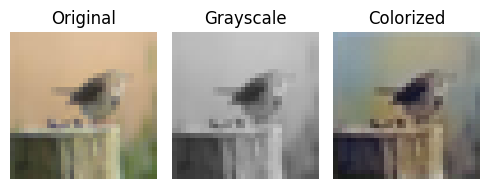

EPOCH: 67.000  val_loss: 0.003  (4830.94s - 2379.42s remaining)

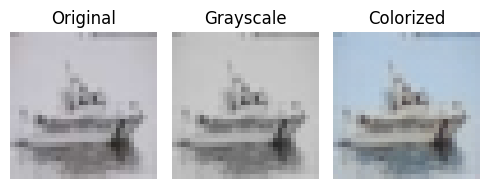

EPOCH: 67.250  train_loss: 0.004  (4847.40s - 2360.63s remaining)

EPOCH: 67.255  train_loss: 0.004  (4847.72s - 2360.24s remaining)

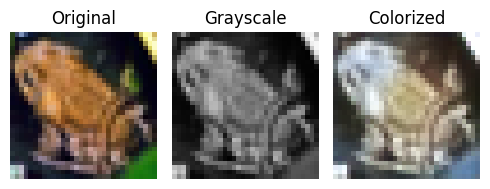

EPOCH: 67.505  train_loss: 0.004  (4863.95s - 2341.36s remaining)

EPOCH: 67.510  train_loss: 0.004  (4864.27s - 2340.97s remaining)

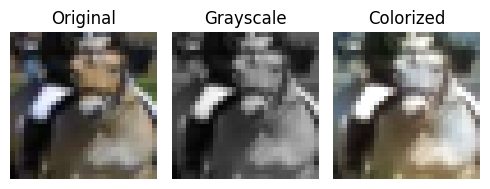

EPOCH: 67.760  train_loss: 0.004  (4880.64s - 2322.17s remaining)

EPOCH: 67.765  train_loss: 0.004  (4880.98s - 2321.79s remaining)

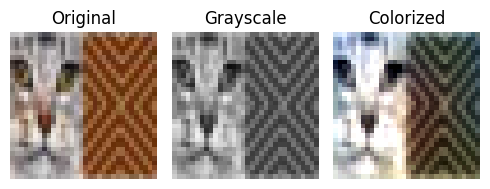

EPOCH: 68.000  val_loss: 0.003  (4903.14s - 2307.36s remaining)

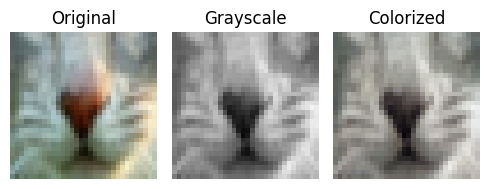

EPOCH: 68.250  train_loss: 0.004  (4919.56s - 2288.59s remaining)

EPOCH: 68.255  train_loss: 0.003  (4919.88s - 2288.19s remaining)

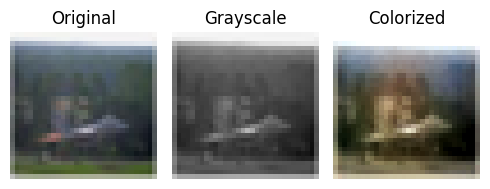

EPOCH: 68.510  train_loss: 0.003  (4936.37s - 2268.94s remaining)

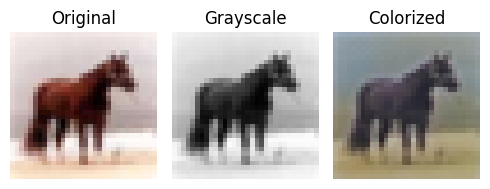

EPOCH: 68.760  train_loss: 0.004  (4952.52s - 2250.08s remaining)

EPOCH: 68.765  train_loss: 0.003  (4952.84s - 2249.69s remaining)

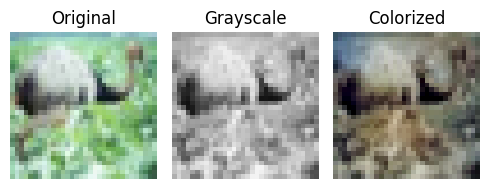

EPOCH: 69.000  val_loss: 0.003  (4975.07s - 2235.18s remaining)

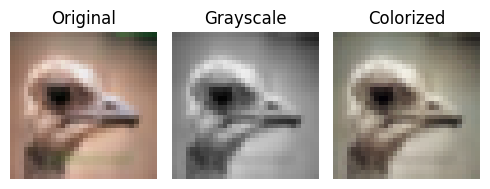

EPOCH: 69.250  train_loss: 0.004  (4991.26s - 2216.33s remaining)

EPOCH: 69.255  train_loss: 0.004  (4991.60s - 2215.96s remaining)

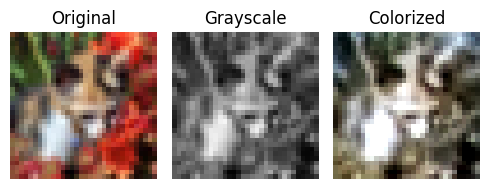

EPOCH: 69.505  train_loss: 0.004  (5007.98s - 2197.22s remaining)

EPOCH: 69.510  train_loss: 0.004  (5008.30s - 2196.83s remaining)

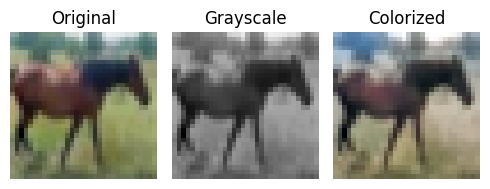

EPOCH: 69.760  train_loss: 0.003  (5024.53s - 2178.04s remaining)

EPOCH: 69.765  train_loss: 0.004  (5024.84s - 2177.65s remaining)

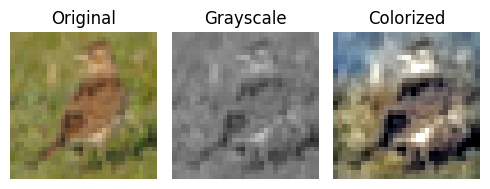

EPOCH: 70.000  val_loss: 0.005  train_loss: 0.004  (5047.68s - 2163.29s remaining)


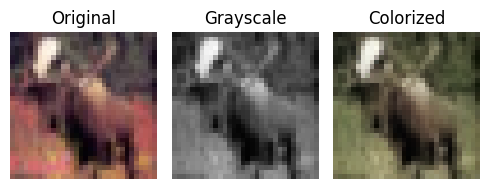

EPOCH: 70.250  train_loss: 0.004  (5063.83s - 2144.47s remaining)

EPOCH: 70.255  train_loss: 0.005  (5064.14s - 2144.08s remaining)

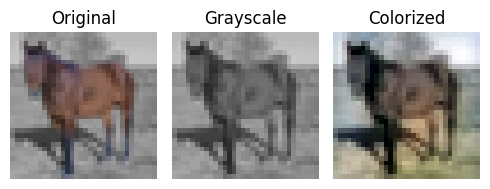

EPOCH: 70.505  train_loss: 0.004  (5080.67s - 2125.43s remaining)

EPOCH: 70.510  train_loss: 0.004  (5081.00s - 2125.05s remaining)

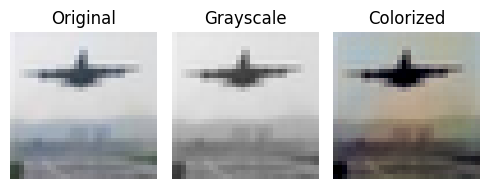

EPOCH: 70.760  train_loss: 0.005  (5097.28s - 2106.32s remaining)

EPOCH: 70.765  train_loss: 0.005  (5097.60s - 2105.93s remaining)

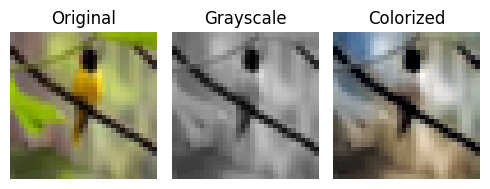

EPOCH: 71.000  val_loss: 0.003  (5120.09s - 2091.31s remaining)

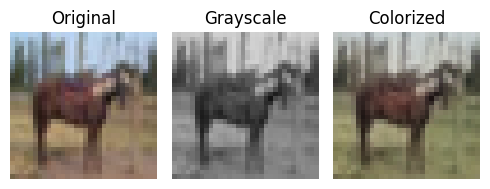

EPOCH: 71.250  train_loss: 0.004  (5136.34s - 2072.56s remaining)

EPOCH: 71.255  train_loss: 0.004  (5136.65s - 2072.17s remaining)

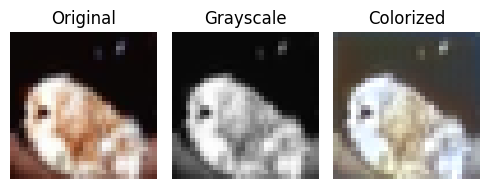

EPOCH: 71.505  train_loss: 0.004  (5153.15s - 2053.54s remaining)

EPOCH: 71.510  train_loss: 0.004  (5153.47s - 2053.15s remaining)

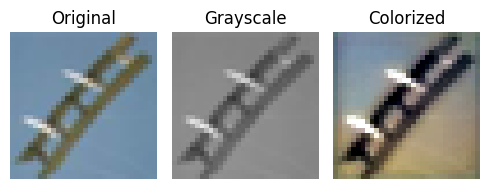

EPOCH: 71.765  train_loss: 0.004  (5170.00s - 2034.04s remaining)

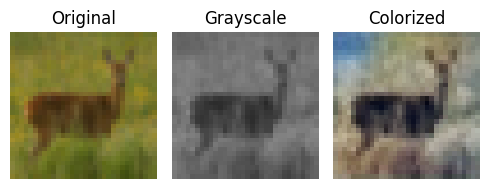

EPOCH: 72.000  val_loss: 0.003  (5192.40s - 2019.27s remaining)

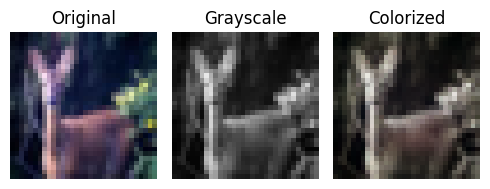

EPOCH: 72.250  train_loss: 0.004  (5208.61s - 2000.54s remaining)

EPOCH: 72.255  train_loss: 0.004  (5208.93s - 2000.15s remaining)

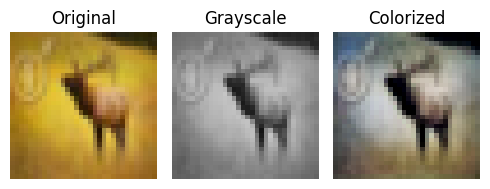

EPOCH: 72.505  train_loss: 0.004  (5225.13s - 1981.44s remaining)

EPOCH: 72.510  train_loss: 0.004  (5225.47s - 1981.06s remaining)

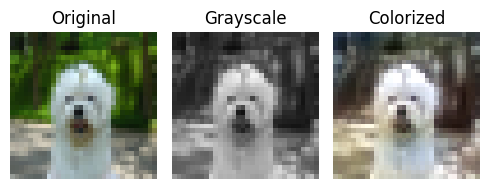

EPOCH: 72.760  train_loss: 0.004  (5242.13s - 1962.54s remaining)

EPOCH: 72.765  train_loss: 0.004  (5242.46s - 1962.15s remaining)

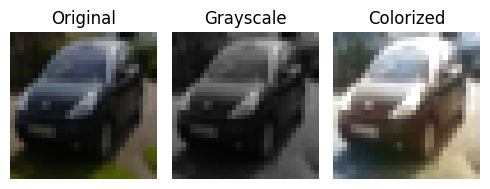

EPOCH: 73.000  val_loss: 0.003  (5264.94s - 1947.31s remaining)

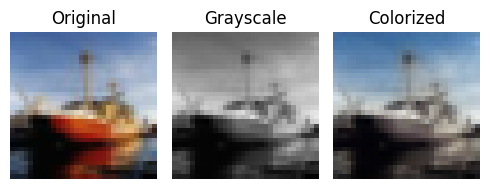

EPOCH: 73.250  train_loss: 0.004  (5281.12s - 1928.60s remaining)

EPOCH: 73.255  train_loss: 0.004  (5281.44s - 1928.21s remaining)

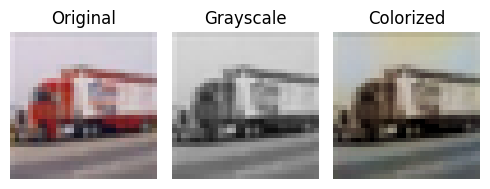

EPOCH: 73.505  train_loss: 0.004  (5297.68s - 1909.55s remaining)

EPOCH: 73.510  train_loss: 0.004  (5298.00s - 1909.16s remaining)

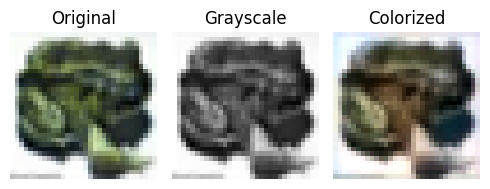

EPOCH: 73.760  train_loss: 0.004  (5314.38s - 1890.56s remaining)

EPOCH: 73.765  train_loss: 0.004  (5314.71s - 1890.18s remaining)

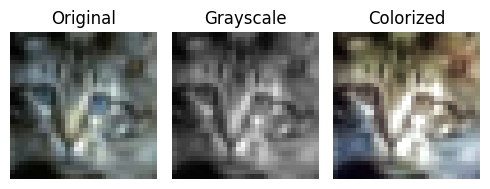

EPOCH: 74.000  val_loss: 0.003  (5336.97s - 1875.15s remaining)

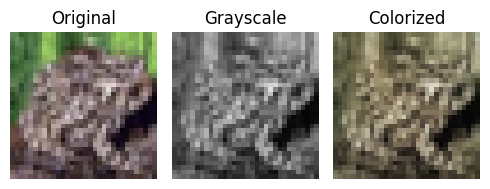

EPOCH: 74.250  train_loss: 0.004  (5353.27s - 1856.52s remaining)

EPOCH: 74.255  train_loss: 0.004  (5353.59s - 1856.14s remaining)

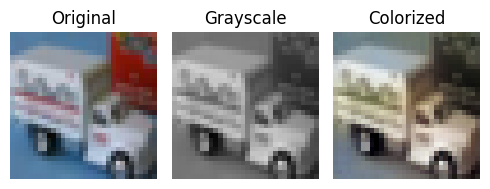

EPOCH: 74.505  train_loss: 0.004  (5369.73s - 1837.47s remaining)

EPOCH: 74.510  train_loss: 0.004  (5370.04s - 1837.08s remaining)

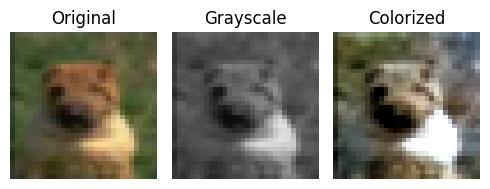

EPOCH: 74.760  train_loss: 0.004  (5386.36s - 1818.49s remaining)

EPOCH: 74.765  train_loss: 0.003  (5386.72s - 1818.12s remaining)

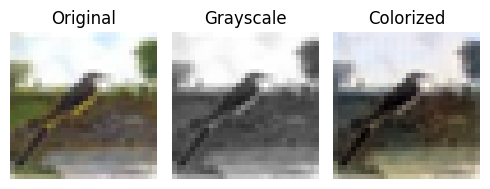

EPOCH: 74.950  val_loss: 0.005  (5408.69s - 1807.71s remaining)

EPOCH: 75.000  val_loss: 0.005  train_loss: 0.004  (5408.90s - 1802.97s remaining)


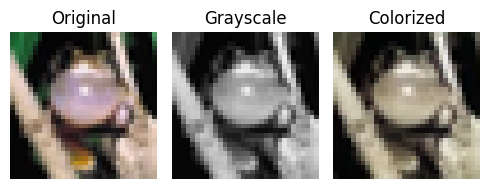

EPOCH: 75.250  train_loss: 0.004  (5425.21s - 1784.37s remaining)

EPOCH: 75.255  train_loss: 0.005  (5425.53s - 1783.99s remaining)

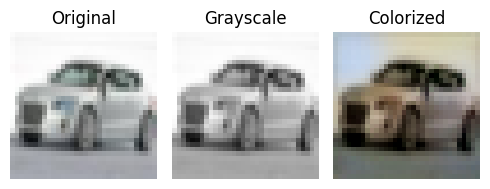

EPOCH: 75.505  train_loss: 0.004  (5442.01s - 1765.46s remaining)

EPOCH: 75.510  train_loss: 0.004  (5442.33s - 1765.08s remaining)

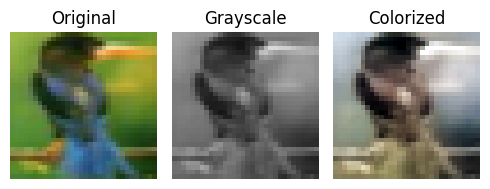

EPOCH: 75.760  train_loss: 0.004  (5458.60s - 1746.50s remaining)

EPOCH: 75.765  train_loss: 0.004  (5458.92s - 1746.12s remaining)

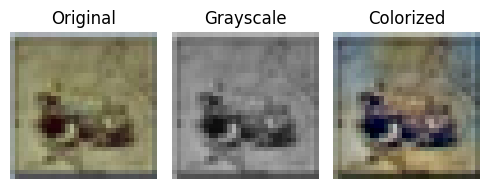

EPOCH: 76.000  val_loss: 0.003  (5481.27s - 1730.93s remaining)

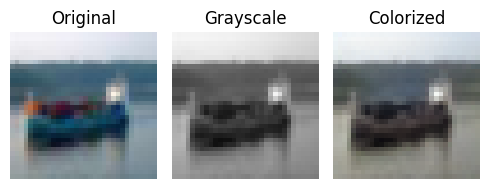

EPOCH: 76.250  train_loss: 0.004  (5497.56s - 1712.35s remaining)

EPOCH: 76.255  train_loss: 0.004  (5497.92s - 1711.99s remaining)

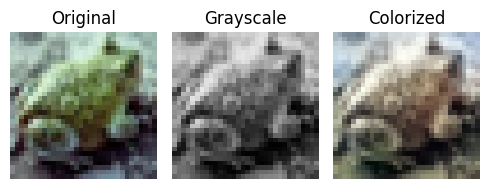

EPOCH: 76.505  train_loss: 0.004  (5514.29s - 1693.45s remaining)

EPOCH: 76.510  train_loss: 0.004  (5514.61s - 1693.07s remaining)

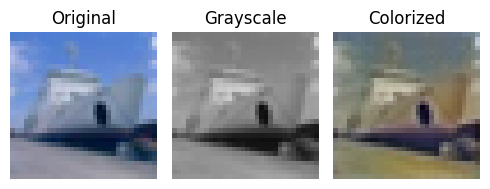

EPOCH: 76.760  train_loss: 0.004  (5530.86s - 1674.51s remaining)

EPOCH: 76.765  train_loss: 0.004  (5531.18s - 1674.13s remaining)

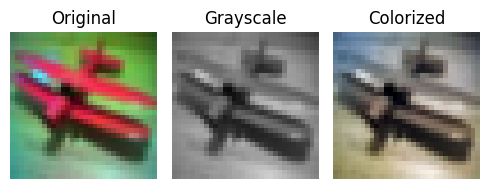

EPOCH: 77.000  val_loss: 0.003  (5553.52s - 1658.84s remaining)

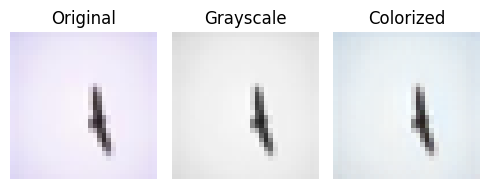

EPOCH: 77.250  train_loss: 0.004  (5569.75s - 1640.28s remaining)

EPOCH: 77.255  train_loss: 0.003  (5570.06s - 1639.90s remaining)

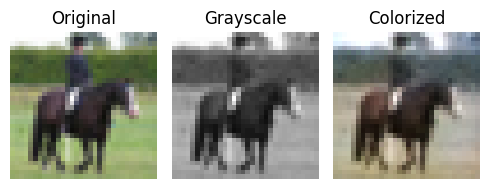

EPOCH: 77.505  train_loss: 0.004  (5586.47s - 1621.41s remaining)

EPOCH: 77.510  train_loss: 0.004  (5586.79s - 1621.02s remaining)

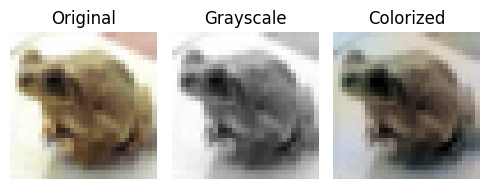

EPOCH: 77.765  train_loss: 0.004  (5603.35s - 1602.11s remaining)

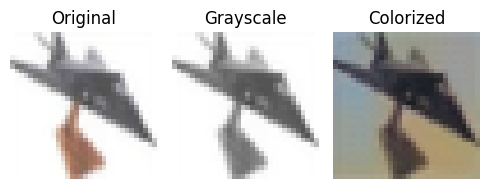

EPOCH: 78.000  val_loss: 0.003  (5626.02s - 1586.83s remaining)

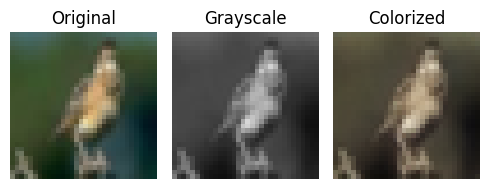

EPOCH: 78.250  train_loss: 0.004  (5642.58s - 1568.39s remaining)

EPOCH: 78.255  train_loss: 0.004  (5642.90s - 1568.00s remaining)

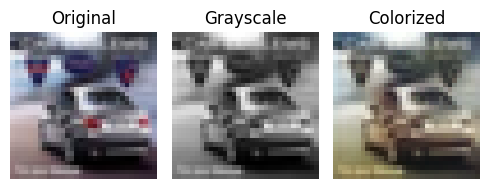

EPOCH: 78.505  train_loss: 0.003  (5659.39s - 1549.56s remaining)

EPOCH: 78.510  train_loss: 0.004  (5659.75s - 1549.19s remaining)

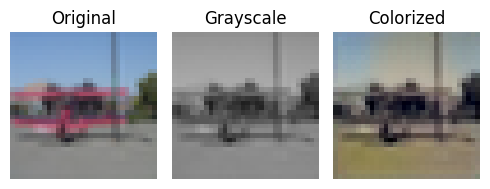

EPOCH: 78.765  train_loss: 0.004  (5676.33s - 1530.31s remaining)

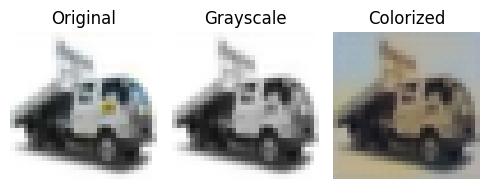

EPOCH: 78.950  val_loss: 0.005  (5698.54s - 1519.37s remaining)

EPOCH: 79.000  val_loss: 0.003  (5698.74s - 1514.86s remaining)

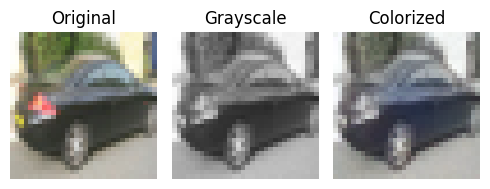

EPOCH: 79.250  train_loss: 0.004  (5715.00s - 1496.36s remaining)

EPOCH: 79.255  train_loss: 0.003  (5715.33s - 1495.98s remaining)

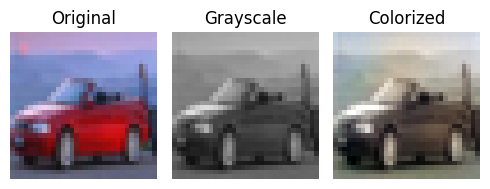

EPOCH: 79.505  train_loss: 0.004  (5731.54s - 1477.48s remaining)

EPOCH: 79.510  train_loss: 0.004  (5731.91s - 1477.11s remaining)

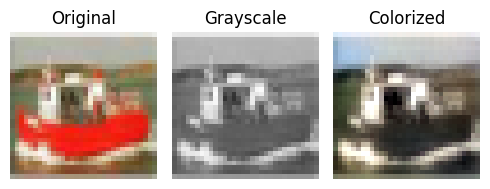

EPOCH: 79.760  train_loss: 0.004  (5748.34s - 1458.69s remaining)

EPOCH: 79.765  train_loss: 0.005  (5748.66s - 1458.31s remaining)

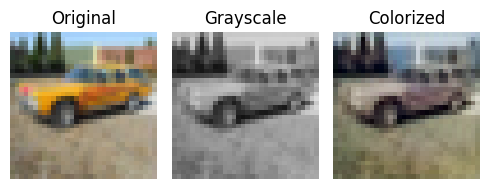

EPOCH: 79.950  val_loss: 0.005  (5770.83s - 1447.22s remaining)

EPOCH: 80.000  val_loss: 0.005  train_loss: 0.004  (5771.09s - 1442.77s remaining)


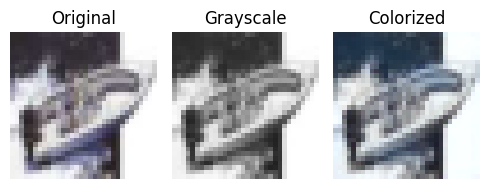

EPOCH: 80.250  train_loss: 0.004  (5787.39s - 1424.31s remaining)

EPOCH: 80.255  train_loss: 0.004  (5787.71s - 1423.93s remaining)

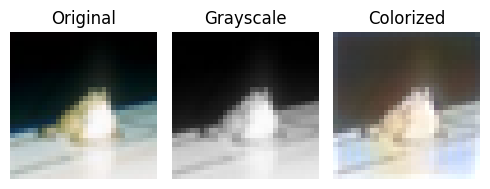

EPOCH: 80.505  train_loss: 0.004  (5803.87s - 1405.45s remaining)

EPOCH: 80.510  train_loss: 0.004  (5804.19s - 1405.07s remaining)

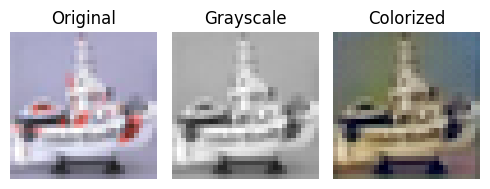

EPOCH: 80.760  train_loss: 0.004  (5820.54s - 1386.65s remaining)

EPOCH: 80.765  train_loss: 0.004  (5820.90s - 1386.28s remaining)

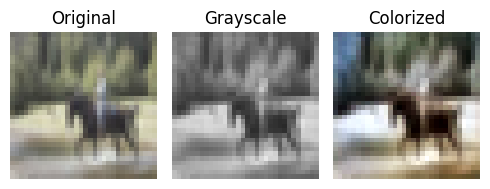

EPOCH: 81.000  val_loss: 0.003  (5843.25s - 1370.64s remaining)

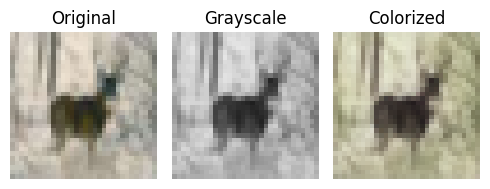

EPOCH: 81.250  train_loss: 0.004  (5859.78s - 1352.26s remaining)

EPOCH: 81.255  train_loss: 0.004  (5860.10s - 1351.88s remaining)

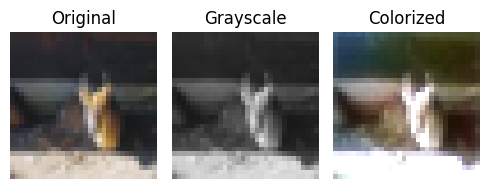

EPOCH: 81.505  train_loss: 0.004  (5876.41s - 1333.46s remaining)

EPOCH: 81.510  train_loss: 0.004  (5876.73s - 1333.08s remaining)

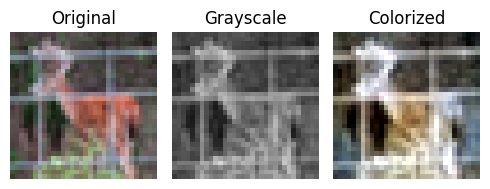

EPOCH: 81.760  train_loss: 0.004  (5893.01s - 1314.66s remaining)

EPOCH: 81.765  train_loss: 0.003  (5893.33s - 1314.29s remaining)

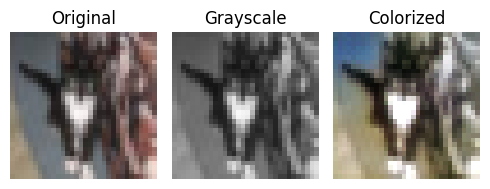

EPOCH: 82.000  val_loss: 0.003  (5915.70s - 1298.57s remaining)

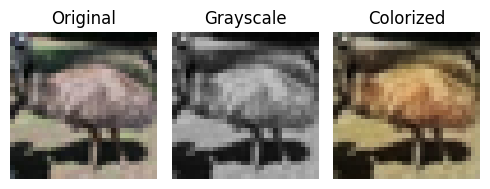

EPOCH: 82.255  train_loss: 0.004  (5932.44s - 1279.81s remaining)

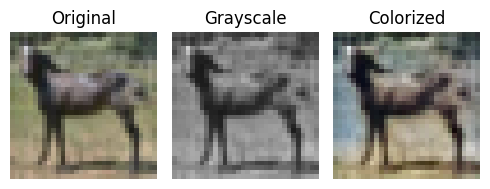

EPOCH: 82.505  train_loss: 0.004  (5948.81s - 1261.42s remaining)

EPOCH: 82.510  train_loss: 0.004  (5949.13s - 1261.04s remaining)

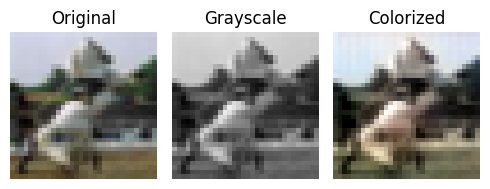

EPOCH: 82.760  train_loss: 0.004  (5965.35s - 1242.64s remaining)

EPOCH: 82.765  train_loss: 0.004  (5965.67s - 1242.27s remaining)

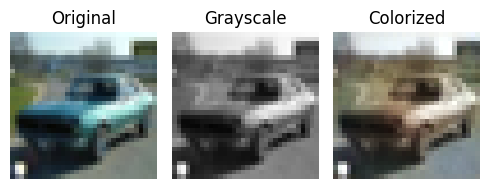

EPOCH: 83.000  val_loss: 0.003  (5988.11s - 1226.48s remaining)

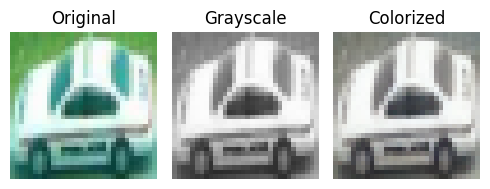

EPOCH: 83.250  train_loss: 0.004  (6004.56s - 1208.12s remaining)

EPOCH: 83.255  train_loss: 0.004  (6004.89s - 1207.75s remaining)

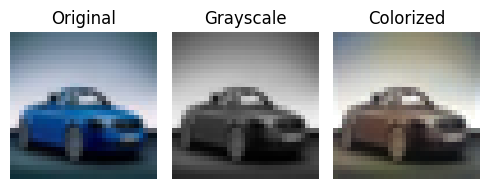

EPOCH: 83.510  train_loss: 0.004  (6022.22s - 1189.14s remaining)

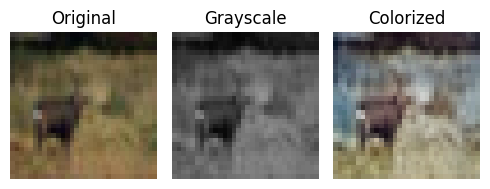

EPOCH: 83.765  train_loss: 0.004  (6038.73s - 1170.38s remaining)

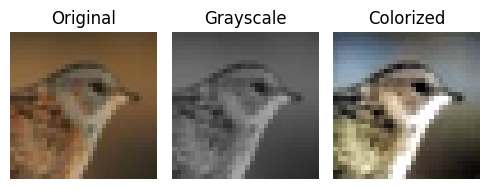

EPOCH: 84.000  val_loss: 0.003  (6061.52s - 1154.58s remaining)

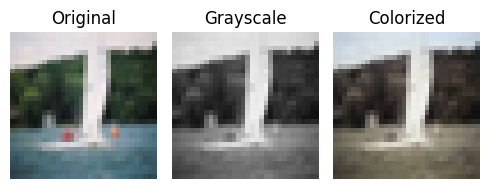

EPOCH: 84.250  train_loss: 0.003  (6077.82s - 1136.21s remaining)

EPOCH: 84.255  train_loss: 0.004  (6078.14s - 1135.83s remaining)

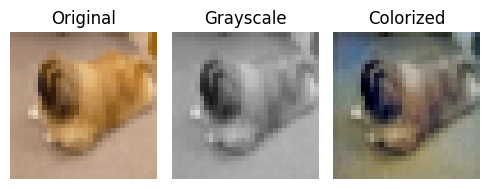

EPOCH: 84.505  train_loss: 0.004  (6094.55s - 1117.50s remaining)

EPOCH: 84.510  train_loss: 0.003  (6094.89s - 1117.13s remaining)

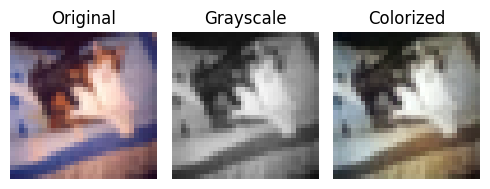

EPOCH: 84.760  train_loss: 0.004  (6111.34s - 1098.81s remaining)

EPOCH: 84.765  train_loss: 0.004  (6111.68s - 1098.44s remaining)

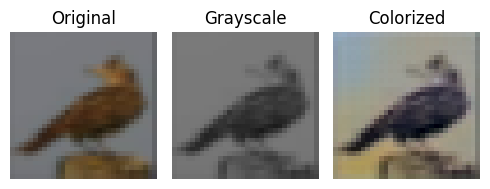

EPOCH: 85.000  val_loss: 0.005  train_loss: 0.004  (6134.30s - 1082.52s remaining)


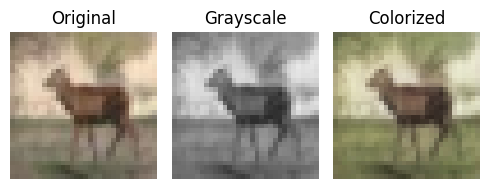

EPOCH: 85.250  train_loss: 0.004  (6150.49s - 1064.16s remaining)

EPOCH: 85.255  train_loss: 0.004  (6150.81s - 1063.78s remaining)

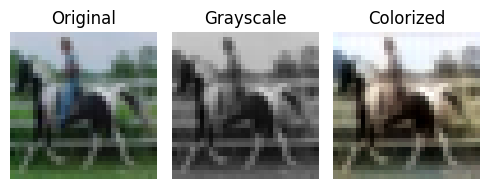

EPOCH: 85.505  train_loss: 0.004  (6167.07s - 1045.45s remaining)

EPOCH: 85.510  train_loss: 0.004  (6167.39s - 1045.07s remaining)

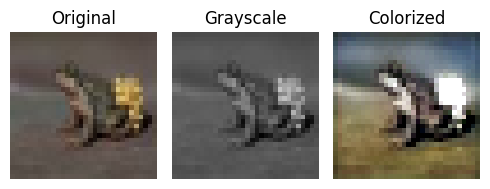

EPOCH: 85.765  train_loss: 0.004  (6184.22s - 1026.41s remaining)

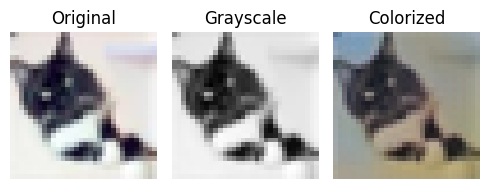

EPOCH: 86.000  val_loss: 0.003  (6206.38s - 1010.34s remaining)

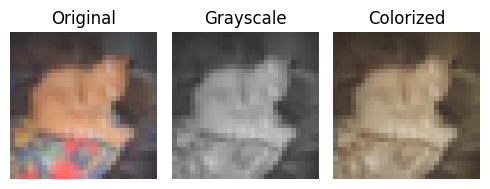

EPOCH: 86.250  train_loss: 0.004  (6222.73s - 992.03s remaining)

EPOCH: 86.255  train_loss: 0.004  (6223.05s - 991.65s remaining)

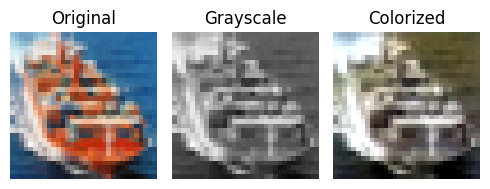

EPOCH: 86.510  train_loss: 0.005  (6239.63s - 972.96s remaining)

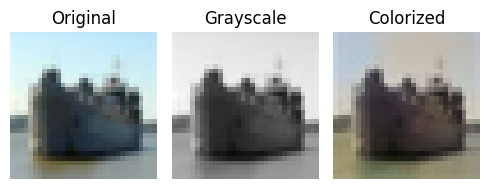

EPOCH: 86.765  train_loss: 0.004  (6256.55s - 954.34s remaining)

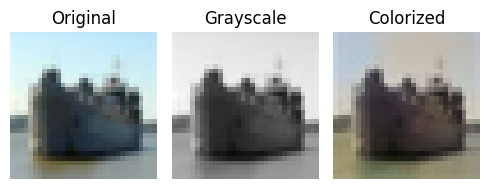

EPOCH: 87.000  val_loss: 0.003  (6278.67s - 938.19s remaining)

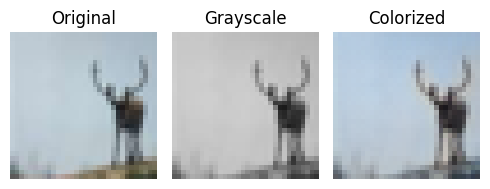

EPOCH: 87.250  train_loss: 0.003  (6295.24s - 919.93s remaining)

EPOCH: 87.255  train_loss: 0.004  (6295.55s - 919.56s remaining)

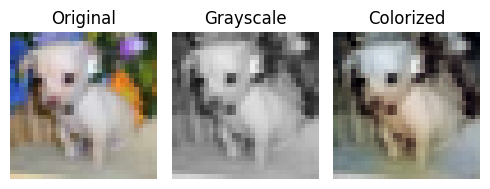

EPOCH: 87.505  train_loss: 0.004  (6311.85s - 901.27s remaining)

EPOCH: 87.510  train_loss: 0.004  (6312.18s - 900.90s remaining)

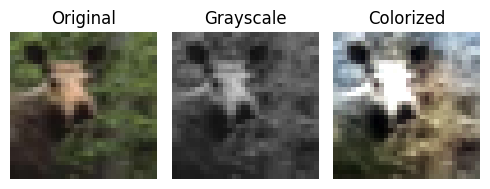

EPOCH: 87.765  train_loss: 0.004  (6328.80s - 882.25s remaining)

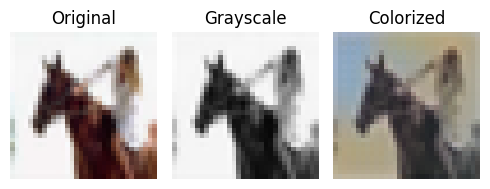

EPOCH: 88.000  val_loss: 0.003  (6351.22s - 866.08s remaining)

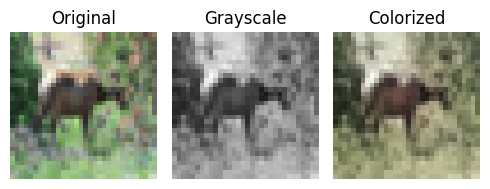

EPOCH: 88.250  train_loss: 0.004  (6367.51s - 847.80s remaining)

EPOCH: 88.255  train_loss: 0.005  (6367.85s - 847.43s remaining)

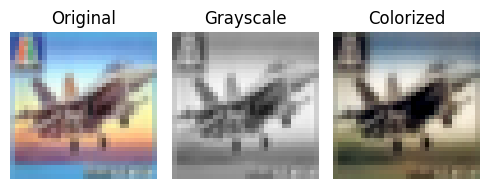

EPOCH: 88.505  train_loss: 0.004  (6384.30s - 829.18s remaining)

EPOCH: 88.510  train_loss: 0.004  (6384.62s - 828.81s remaining)

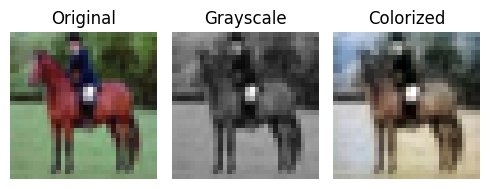

EPOCH: 88.765  train_loss: 0.004  (6401.17s - 810.17s remaining)

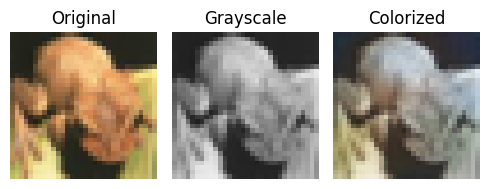

EPOCH: 89.000  val_loss: 0.003  (6423.74s - 793.95s remaining)

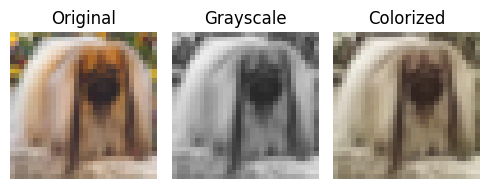

EPOCH: 89.250  train_loss: 0.004  (6439.92s - 775.68s remaining)

EPOCH: 89.255  train_loss: 0.004  (6440.24s - 775.30s remaining)

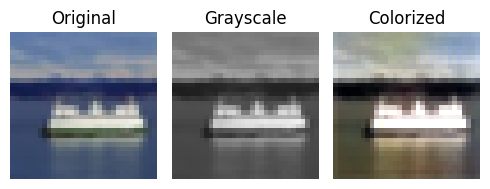

EPOCH: 89.505  train_loss: 0.004  (6457.04s - 757.12s remaining)

EPOCH: 89.510  train_loss: 0.004  (6457.41s - 756.75s remaining)

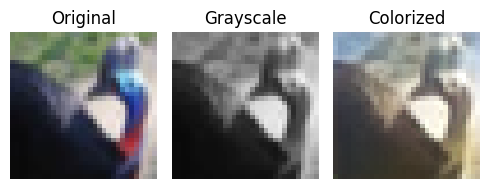

EPOCH: 89.765  train_loss: 0.004  (6474.06s - 738.15s remaining)

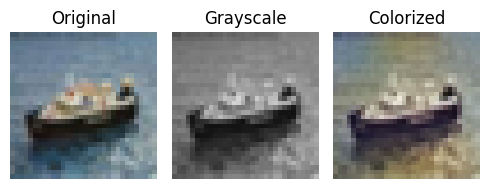

EPOCH: 90.000  val_loss: 0.005  train_loss: 0.004  (6496.69s - 721.85s remaining)


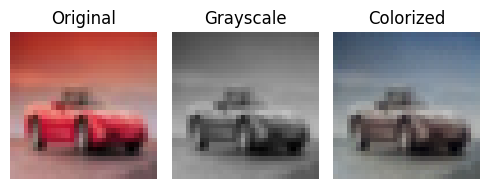

EPOCH: 90.250  train_loss: 0.004  (6512.94s - 703.61s remaining)

EPOCH: 90.255  train_loss: 0.004  (6513.25s - 703.24s remaining)

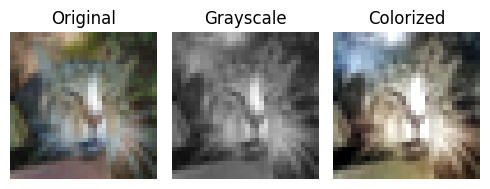

EPOCH: 90.505  train_loss: 0.004  (6529.55s - 685.02s remaining)

EPOCH: 90.510  train_loss: 0.004  (6529.87s - 684.64s remaining)

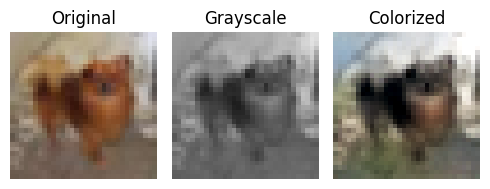

EPOCH: 90.765  train_loss: 0.004  (6546.77s - 666.09s remaining)

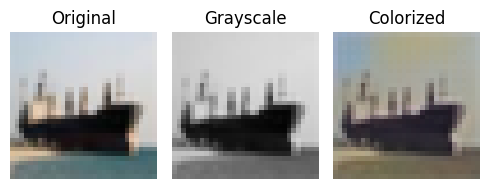

EPOCH: 90.950  val_loss: 0.005  (6568.87s - 653.64s remaining)

EPOCH: 91.000  val_loss: 0.003  (6569.10s - 649.69s remaining)

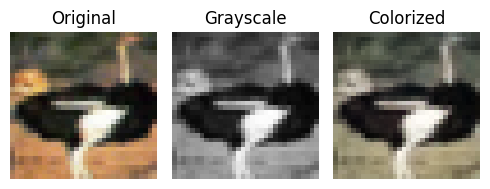

EPOCH: 91.250  train_loss: 0.003  (6585.63s - 631.50s remaining)

EPOCH: 91.255  train_loss: 0.004  (6585.95s - 631.13s remaining)

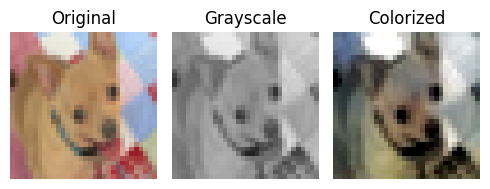

EPOCH: 91.510  train_loss: 0.004  (6602.52s - 612.54s remaining)

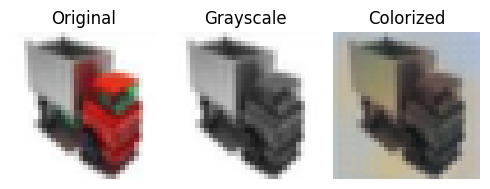

EPOCH: 91.760  train_loss: 0.005  (6618.80s - 594.35s remaining)

EPOCH: 91.765  train_loss: 0.004  (6619.15s - 593.98s remaining)

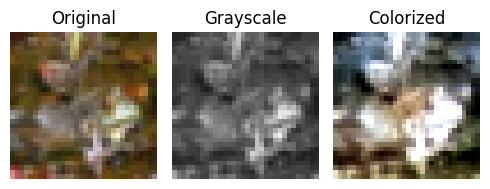

EPOCH: 92.000  val_loss: 0.003  (6641.44s - 577.52s remaining)

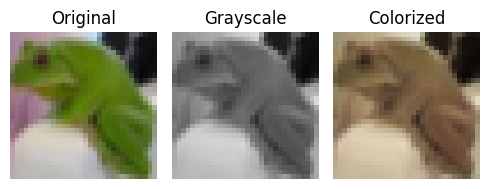

EPOCH: 92.250  train_loss: 0.004  (6658.25s - 559.36s remaining)

EPOCH: 92.255  train_loss: 0.004  (6658.61s - 559.00s remaining)

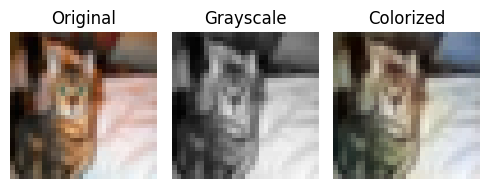

EPOCH: 92.505  train_loss: 0.004  (6674.93s - 540.81s remaining)

EPOCH: 92.510  train_loss: 0.004  (6675.24s - 540.44s remaining)

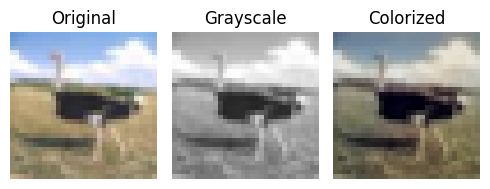

EPOCH: 92.760  train_loss: 0.004  (6691.49s - 522.26s remaining)

EPOCH: 92.765  train_loss: 0.004  (6691.81s - 521.89s remaining)

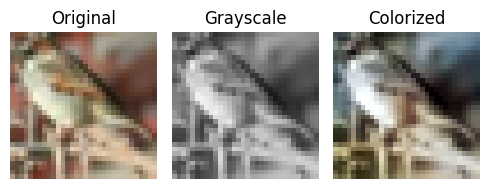

EPOCH: 93.000  val_loss: 0.003  (6714.50s - 505.39s remaining)

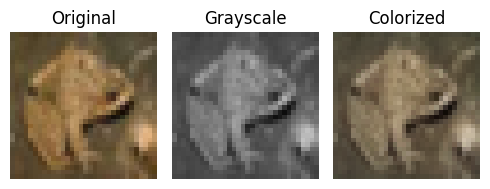

EPOCH: 93.250  train_loss: 0.004  (6730.77s - 487.21s remaining)

EPOCH: 93.255  train_loss: 0.003  (6731.08s - 486.84s remaining)

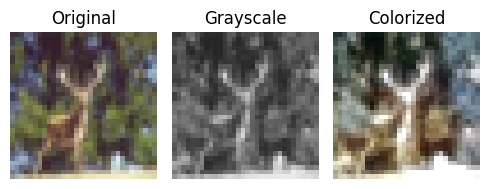

EPOCH: 93.505  train_loss: 0.004  (6747.66s - 468.70s remaining)

EPOCH: 93.510  train_loss: 0.004  (6747.98s - 468.32s remaining)

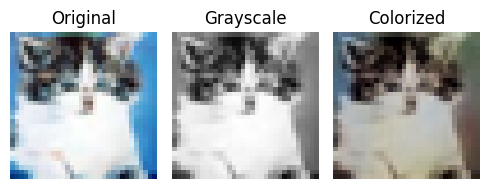

EPOCH: 93.760  train_loss: 0.004  (6764.32s - 450.17s remaining)

EPOCH: 93.765  train_loss: 0.005  (6764.65s - 449.80s remaining)

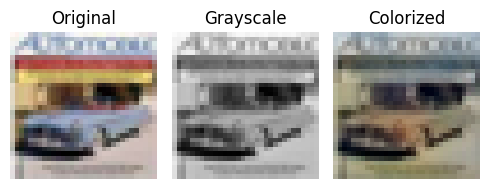

EPOCH: 94.000  val_loss: 0.003  (6787.26s - 433.23s remaining)

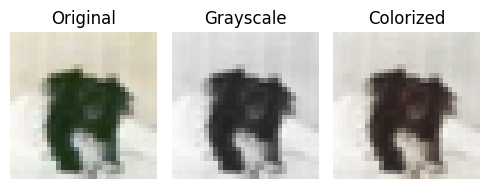

EPOCH: 94.250  train_loss: 0.003  (6803.53s - 415.07s remaining)

EPOCH: 94.255  train_loss: 0.004  (6803.85s - 414.70s remaining)

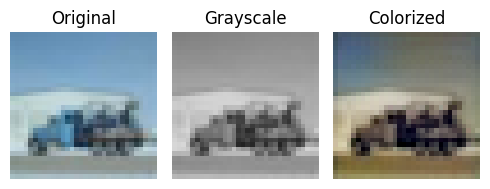

EPOCH: 94.510  train_loss: 0.004  (6820.67s - 396.19s remaining)

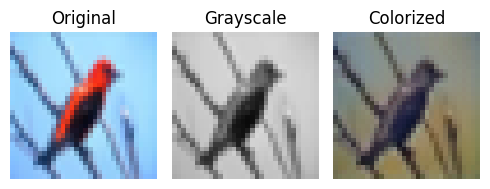

EPOCH: 94.760  train_loss: 0.004  (6837.05s - 378.06s remaining)

EPOCH: 94.765  train_loss: 0.004  (6837.37s - 377.69s remaining)

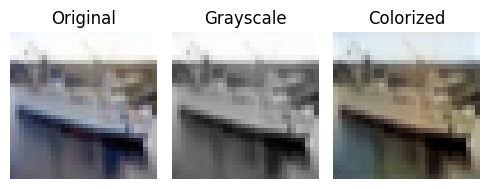

EPOCH: 95.000  val_loss: 0.005  train_loss: 0.004  (6860.07s - 361.06s remaining)


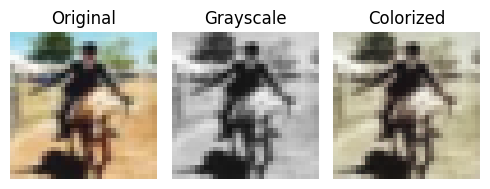

EPOCH: 95.250  train_loss: 0.004  (6876.61s - 342.93s remaining)

EPOCH: 95.255  train_loss: 0.004  (6876.94s - 342.56s remaining)

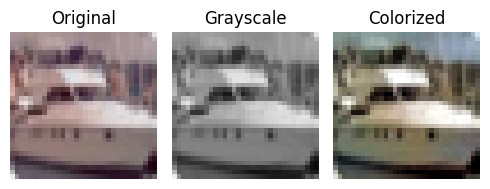

EPOCH: 95.505  train_loss: 0.004  (6893.21s - 324.43s remaining)

EPOCH: 95.510  train_loss: 0.003  (6893.54s - 324.06s remaining)

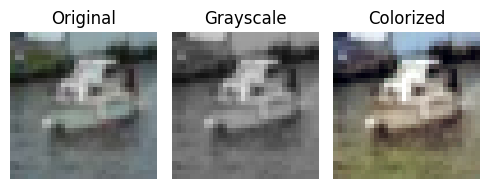

EPOCH: 95.765  train_loss: 0.004  (6910.48s - 305.58s remaining)

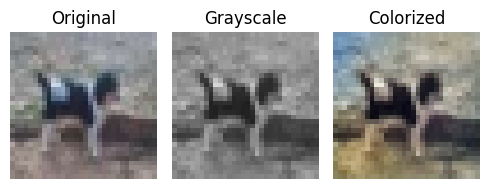

EPOCH: 95.950  val_loss: 0.005  (6932.48s - 292.62s remaining)

EPOCH: 96.000  val_loss: 0.003  (6932.73s - 288.86s remaining)

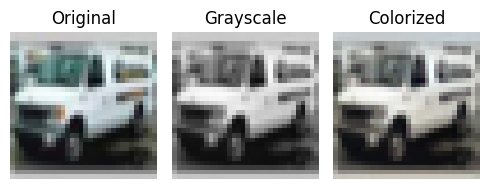

EPOCH: 96.250  train_loss: 0.004  (6949.36s - 270.75s remaining)

EPOCH: 96.255  train_loss: 0.004  (6949.67s - 270.38s remaining)

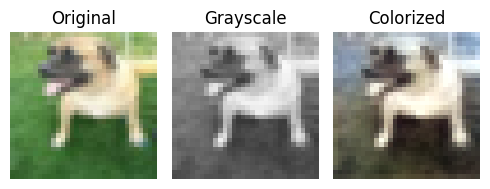

EPOCH: 96.505  train_loss: 0.004  (6966.07s - 252.27s remaining)

EPOCH: 96.510  train_loss: 0.004  (6966.39s - 251.90s remaining)

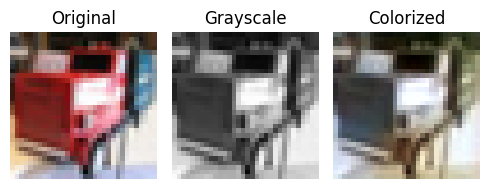

EPOCH: 96.765  train_loss: 0.004  (6983.16s - 233.43s remaining)

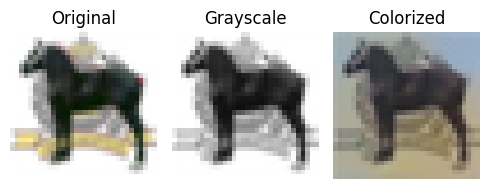

EPOCH: 96.950  val_loss: 0.005  (7005.37s - 220.39s remaining)

EPOCH: 97.000  val_loss: 0.003  (7005.59s - 216.67s remaining)

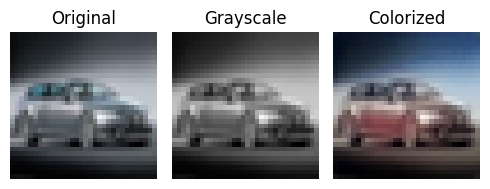

EPOCH: 97.250  train_loss: 0.004  (7022.22s - 198.57s remaining)

EPOCH: 97.255  train_loss: 0.004  (7022.58s - 198.20s remaining)

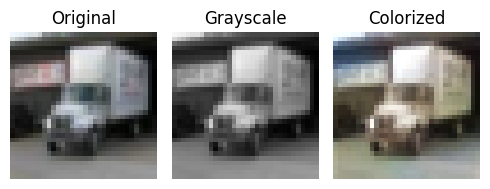

EPOCH: 97.505  train_loss: 0.004  (7038.89s - 180.11s remaining)

EPOCH: 97.510  train_loss: 0.004  (7039.21s - 179.74s remaining)

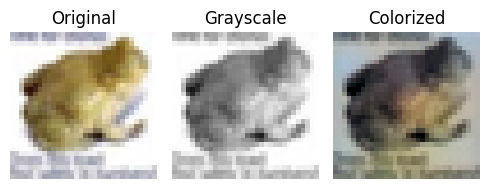

EPOCH: 97.760  train_loss: 0.003  (7055.62s - 161.65s remaining)

EPOCH: 97.765  train_loss: 0.004  (7055.94s - 161.28s remaining)

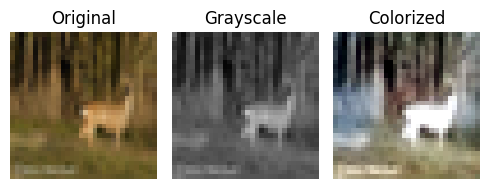

EPOCH: 98.000  val_loss: 0.003  (7079.02s - 144.47s remaining)

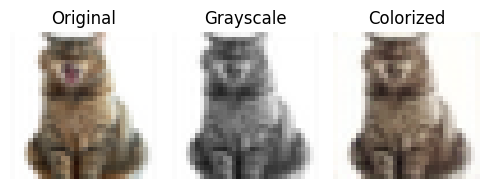

EPOCH: 98.250  train_loss: 0.004  (7095.43s - 126.38s remaining)

EPOCH: 98.255  train_loss: 0.004  (7095.78s - 126.01s remaining)

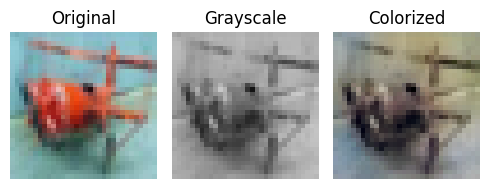

EPOCH: 98.505  train_loss: 0.003  (7112.37s - 107.94s remaining)

EPOCH: 98.510  train_loss: 0.004  (7112.70s - 107.57s remaining)

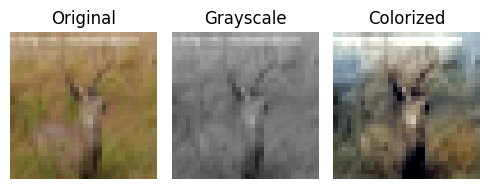

EPOCH: 98.760  train_loss: 0.004  (7129.05s - 89.50s remaining)

EPOCH: 98.765  train_loss: 0.004  (7129.37s - 89.13s remaining)

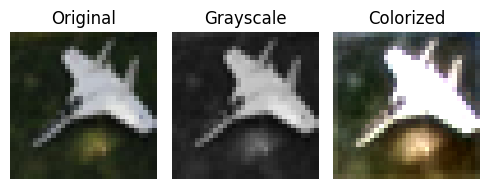

EPOCH: 99.000  val_loss: 0.003  (7152.18s - 72.24s remaining)

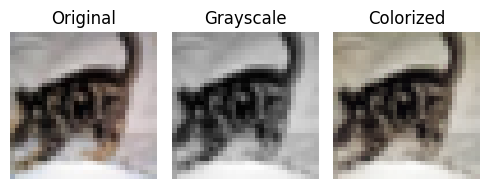

EPOCH: 99.255  train_loss: 0.003  (7168.79s - 53.80s remaining)

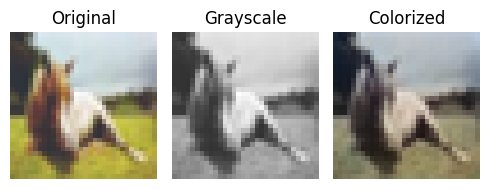

EPOCH: 99.510  train_loss: 0.004  (7185.63s - 35.37s remaining)

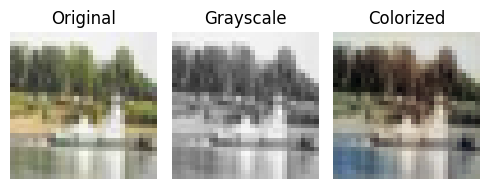

EPOCH: 99.760  train_loss: 0.004  (7202.12s - 17.31s remaining)

EPOCH: 99.765  train_loss: 0.003  (7202.44s - 16.94s remaining)

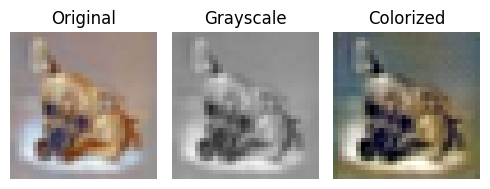

EPOCH: 100.000  val_loss: 0.005  train_loss: 0.004  (7225.23s - 0.00s remaining)


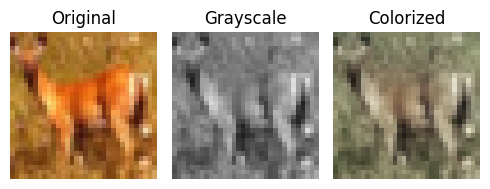

In [16]:
# Train the model
model, criterion, optimizer = load_model()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_dl, val_dl = load_data()
_val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)
n_epochs = 100

log = Report(n_epochs)
for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, end='\r')
        if (i+1) % 50 == 0:
            bw_image, image = next(iter(_val_dl))
            pred_image = model(bw_image)
            subplots([image[0].cpu(), bw_image[0].cpu(), pred_image[0].cpu()], titles=['Original', 'Grayscale', 'Colorized'], nc=3, figsize=(5, 5))

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, end='\r')

    exp_lr_scheduler.step()
    if (epoch+1) % 5 == 0:
        log.report_avgs(epoch+1)

    bw_image, image = next(iter(_val_dl))
    pred_image = model(bw_image)
    subplots([image[0].cpu(), bw_image[0].cpu(), pred_image[0].cpu()], titles=['Original', 'Grayscale', 'Colorized'], nc=3, figsize=(5, 5))

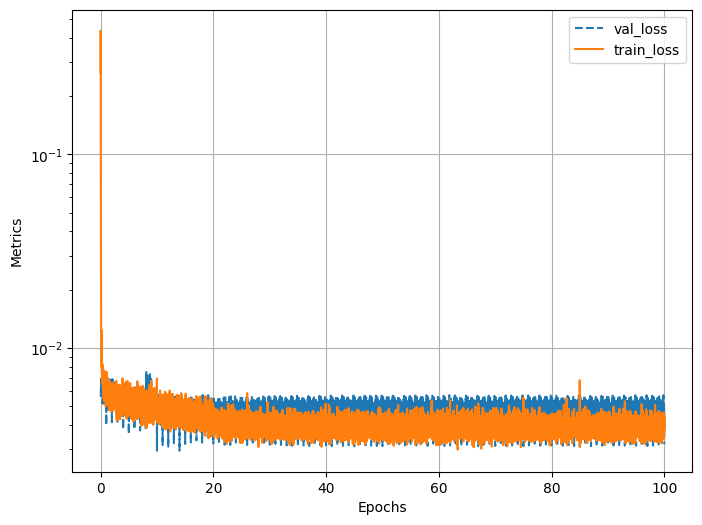

100%|██████████| 201/201 [00:00<00:00, 256.81it/s]


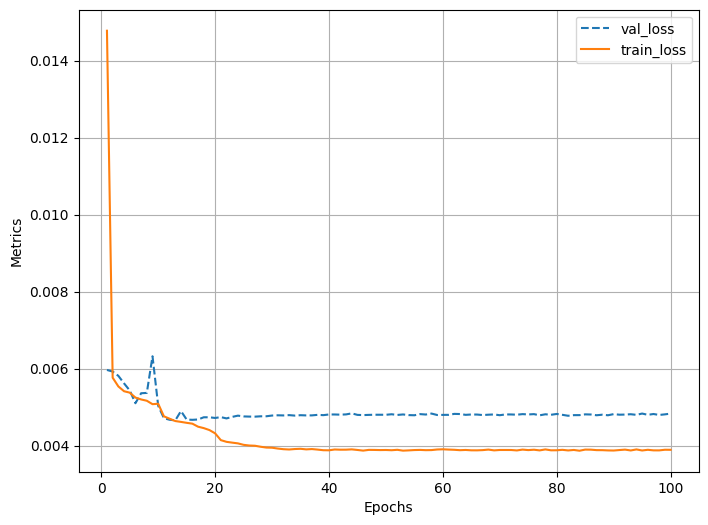

In [17]:
# Plot Training history
log.plot(log=True)
log.plot_epochs()